# Logistic Regression Comprehensive Demo

This notebook demonstrates:
- Basic logistic regression implementation
- Threshold tuning for classification
- Classification metrics evaluation
- Cost curves visualization
- Handling imbalanced datasets

**Target Audience:** Beginners in Machine Learning

**Dataset:** Titanic Survival Prediction (predicting if a passenger survived based on their characteristics)


## 1. Import Required Libraries

We'll use scikit-learn for machine learning, pandas for data manipulation, numpy for numerical operations, and matplotlib/seaborn for visualization.


In [122]:
# Import essential libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler


In [123]:
# Import metrics and visualization tools
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, auc,
                             precision_recall_curve, classification_report,
                             roc_auc_score)
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better-looking plots
sns.set_style("whitegrid")
sns.set_palette("husl")


## 2. Load and Explore the Dataset

We'll use the famous Titanic dataset to predict passenger survival. This is a classic binary classification problem.


In [159]:
# Load Titanic dataset from seaborn (built-in dataset)
df = sns.load_dataset('titanic')

# Display first few rows
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [142]:
# Check for missing values
print("Missing values per column:")
print(df.isna().sum())
print("\nData types:")
print(df.dtypes)


Missing values per column:
survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

Data types:
survived          int64
pclass            int64
sex              object
age             float64
sibsp             int64
parch             int64
fare            float64
embarked         object
class          category
who              object
adult_male         bool
deck           category
embark_town      object
alive            object
alone              bool
dtype: object


In [160]:
# Select features for modeling
# We'll use: age, fare, sex, class, and number of siblings/spouses
features = ['age', 'sex', 'class', 'sibsp']

# Create feature matrix X
X = df[features].copy()


In [161]:
# Create target variable (survived: 0 = No, 1 = Yes)
y = df['survived'].copy()

# Display class distribution
print("Class distribution:")
print(y.value_counts())
print(f"\nSurvival rate: {y.mean():.2%}")


Class distribution:
survived
0    549
1    342
Name: count, dtype: int64

Survival rate: 38.38%


In [176]:
342/(342+549)

0.3838383838383838

In [162]:
# Handle missing values: fill age with median
X['age'].fillna(X['age'].median(), inplace=True)

# Handle missing values: fill fare with median
#X['fare'].fillna(X['fare'].median(), inplace=True)


/tmp/ipython-input-2367490385.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['age'].fillna(X['age'].median(), inplace=True)


## 3. Preprocess Data

We need to convert categorical variables to numerical format for logistic regression.


In [163]:
# Convert categorical variables to numerical
# Sex: male=0, female=1
X['sex'] = X['sex'].map({'male': 0, 'female': 1})


In [164]:
# Convert class to numerical (First=1, Second=2, Third=3)
X['class'] = X['class'].map({'First': 1, 'Second': 2, 'Third': 3})

# Display processed features
print("Processed features:")
X.head()


Processed features:


,age,sex,class,sibsp
0,22.0,0,3,1
1,38.0,1,1,1
2,26.0,1,3,0
3,35.0,1,1,1
4,35.0,0,3,0


## 4. Split Data into Training and Testing Sets

We split the data to evaluate model performance on unseen data. Using stratify ensures both sets have similar class distributions.

In [148]:
# Split data: 80% training, 20% testing
# stratify=y ensures similar class distribution in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [165]:
# Check split sizes and class distribution
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"\nTraining survival rate: {y_train.mean():.2%}")
print(f"Test survival rate: {y_test.mean():.2%}")


Training set: 712 samples
Test set: 179 samples

Training survival rate: 38.34%
Test survival rate: 38.55%


## 5. Train Logistic Regression Model

Logistic regression predicts probabilities. We'll use default threshold (0.5) initially, then tune it later.


### 5.1 Create and Train the Model

In [166]:
# Create logistic regression model
# max_iter ensures convergence (or prevents infinite loops for iterative solvers),
# random_state for reproducibility
# For Logistic Regression, which is used for classification (predicting probabilities of a categorical outcome), the model uses iterative optimization algorithms (such as gradient descent, or the 'lbfgs' solver which is the default in scikit-learn) to find the coefficients. These algorithms work by repeatedly adjusting the model's parameters to maximize the likelihood of observing the training data.
# Since these are iterative processes, max_iter is indeed necessary. It sets a limit on how many steps the optimization algorithm can take to find the best possible coefficients. Without this limit, if the algorithm struggles to converge, it could potentially run forever, or just take an excessively long time. So, max_iter is crucial for controlling the training process of a Logistic Regression model.

model = LogisticRegression(random_state=42, max_iter=1000)

# Train the model on training data
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

### 5.2 Make Predictions

Logistic regression outputs probabilities. We convert them to binary predictions using a threshold.


In [167]:
# Get predicted probabilities (probability of survival)
# [:, 1] selects probability of class 1 (survived)
y_proba = model.predict_proba(X_test)[:, 1]

# Get binary predictions using default threshold (0.5)
y_pred = model.predict(X_test)


In [168]:
model.predict_proba(X_test)[:, 1]

array([0.07216288, 0.05965729, 0.12585755, 0.03791878, 0.53463649,
       0.45936672, 0.76586105, 0.34688516, 0.30001079, 0.17187761,
       0.10277067, 0.09415294, 0.61043146, 0.19355795, 0.53394429,
       0.11387532, 0.39664305, 0.10284672, 0.14848084, 0.77933694,
       0.10284672, 0.79591466, 0.09598035, 0.47085818, 0.09931775,
       0.94621073, 0.10277067, 0.27473848, 0.09932286, 0.10448314,
       0.08346685, 0.95546596, 0.08024471, 0.11384989, 0.15337349,
       0.17804017, 0.19736312, 0.38086554, 0.10277067, 0.86710158,
       0.14648726, 0.97453228, 0.13559911, 0.87068858, 0.77650818,
       0.1303567 , 0.10321499, 0.41626782, 0.71127798, 0.80431131,
       0.9288673 , 0.60135388, 0.60107661, 0.25253678, 0.74030021,
       0.11014445, 0.08041814, 0.43785358, 0.66341101, 0.44749526,
       0.53392414, 0.74036911, 0.15362871, 0.14932742, 0.42437313,
       0.55883269, 0.92103597, 0.08676393, 0.22606522, 0.28258257,
       0.75069449, 0.1026377 , 0.60115621, 0.961637  , 0.21773

In [169]:
model.predict(X_test)

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0])

In [170]:
# Display some example predictions
print("Sample predictions (first 10):")
print(f"Probabilities: {y_proba[:10]}")
print(f"Binary predictions: {y_pred[:10]}")
print(f"Actual labels: {y_test.values[:10]}")


Sample predictions (first 10):
Probabilities: [0.07216288 0.05965729 0.12585755 0.03791878 0.53463649 0.45936672
 0.76586105 0.34688516 0.30001079 0.17187761]
Binary predictions: [0 0 0 0 1 0 1 0 0 0]
Actual labels: [0 0 1 0 1 1 1 0 0 0]


## 6. Classification Metrics

Metrics help us understand model performance. Different metrics are important for different scenarios.


### 6.1 Confusion Matrix

The confusion matrix shows true positives, true negatives, false positives, and false negatives.


In [171]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
print("Confusion Matrix:")
print(cm)
print("\nFormat: [TN, FP]")
print("        [FN, TP]")


Confusion Matrix:
[[95 15]
 [20 49]]

Format: [TN, FP]
        [FN, TP]


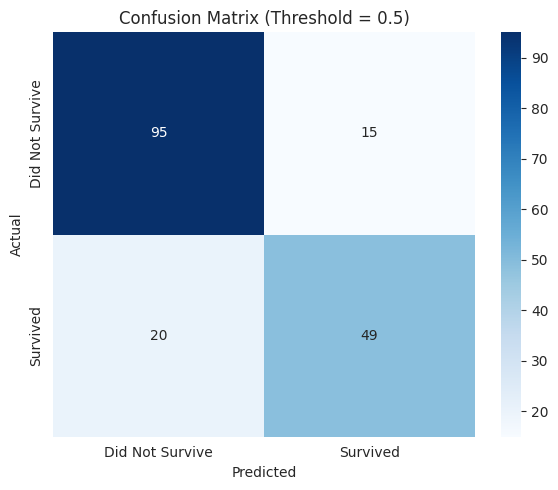

In [172]:
# Visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Did Not Survive', 'Survived'],
            yticklabels=['Did Not Survive', 'Survived'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix (Threshold = 0.5)')
plt.tight_layout()
plt.show()


### 6.2 Basic Classification Metrics

- **Accuracy**: Overall correctness (can be misleading with imbalanced data)
- **Precision**: Of predicted positives, how many are actually positive?
- **Recall**: Of actual positives, how many did we catch?
- **F1-Score**: Harmonic mean of precision and recall


In [173]:
# Calculate key metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Display metrics
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")


# Accuracy:  0.8045
# Precision: 0.7656
# Recall:    0.7101
# F1-Score:  0.7368

Accuracy:  0.8045
Precision: 0.7656
Recall:    0.7101
F1-Score:  0.7368


In [174]:
# Detailed classification report
print(classification_report(y_test, y_pred,
                          target_names=['Did Not Survive', 'Survived']))


                 precision    recall  f1-score   support

Did Not Survive       0.83      0.86      0.84       110
       Survived       0.77      0.71      0.74        69

       accuracy                           0.80       179
      macro avg       0.80      0.79      0.79       179
   weighted avg       0.80      0.80      0.80       179



## 7. Threshold Tuning

The default threshold is 0.5, but this may not be optimal. Different thresholds balance precision and recall differently.

**Edge Case**: When classes are imbalanced, default threshold often favors the majority class.


### 7.1 Understanding Threshold Impact

Lower threshold → More positive predictions → Higher recall, Lower precision
Higher threshold → Fewer positive predictions → Lower recall, Higher precision


In [177]:
# Test different thresholds
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]

# Store results for each threshold
results = []

for threshold in thresholds:
    # Convert probabilities to binary predictions
    y_pred_thresh = (y_proba >= threshold).astype(int)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh)
    rec = recall_score(y_test, y_pred_thresh)
    f1_val = f1_score(y_test, y_pred_thresh)

    results.append({
        'threshold': threshold,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1_val
    })


In [178]:
# Display results as DataFrame
results_df = pd.DataFrame(results)
print("Metrics at Different Thresholds:")
print(results_df.round(4))


Metrics at Different Thresholds:
   threshold  accuracy  precision  recall      f1
0        0.3    0.7709     0.6707  0.7971  0.7285
1        0.4    0.8101     0.7397  0.7826  0.7606
2        0.5    0.8045     0.7656  0.7101  0.7368
3        0.6    0.8045     0.8542  0.5942  0.7009
4        0.7    0.7765     0.9394  0.4493  0.6078


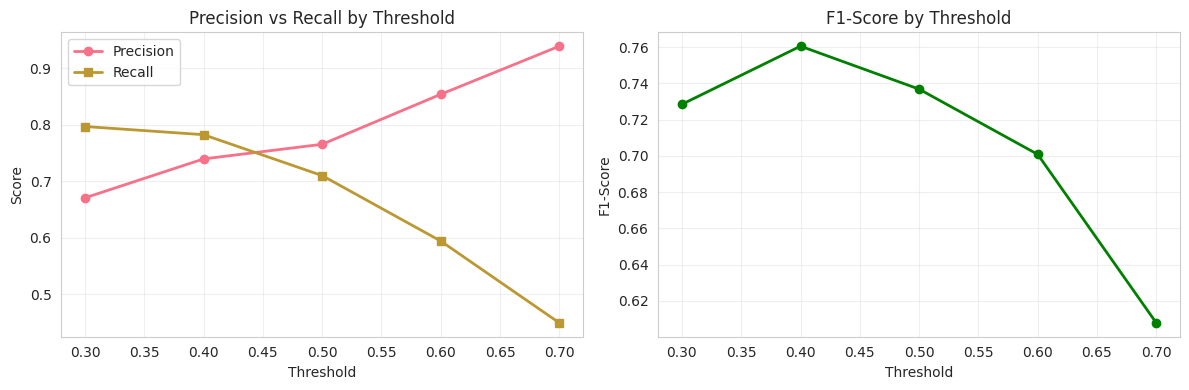

In [179]:
# Visualize threshold impact
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Precision and Recall
axes[0].plot(results_df['threshold'], results_df['precision'],
             'o-', label='Precision', linewidth=2)
axes[0].plot(results_df['threshold'], results_df['recall'],
             's-', label='Recall', linewidth=2)
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title('Precision vs Recall by Threshold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: F1-Score
axes[1].plot(results_df['threshold'], results_df['f1'],
             'o-', color='green', linewidth=2)
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('F1-Score by Threshold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 7.2 Finding Optimal Threshold

We can use F1-score or Youden's J statistic to find the optimal threshold.


In [181]:
# Find threshold that maximizes F1-score
# Test many thresholds between 0 and 1
test_thresholds = np.arange(0.1, 0.9, 0.01)
f1_scores = []

for thresh in test_thresholds:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    f1_scores.append(f1_score(y_test, y_pred_thresh))


In [182]:
# Find optimal threshold (maximizes F1-score)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = test_thresholds[optimal_idx]
optimal_f1 = f1_scores[optimal_idx]

print(f"Optimal threshold: {optimal_threshold:.3f}")
print(f"Optimal F1-score: {optimal_f1:.4f}")


Optimal threshold: 0.420
Optimal F1-score: 0.7660


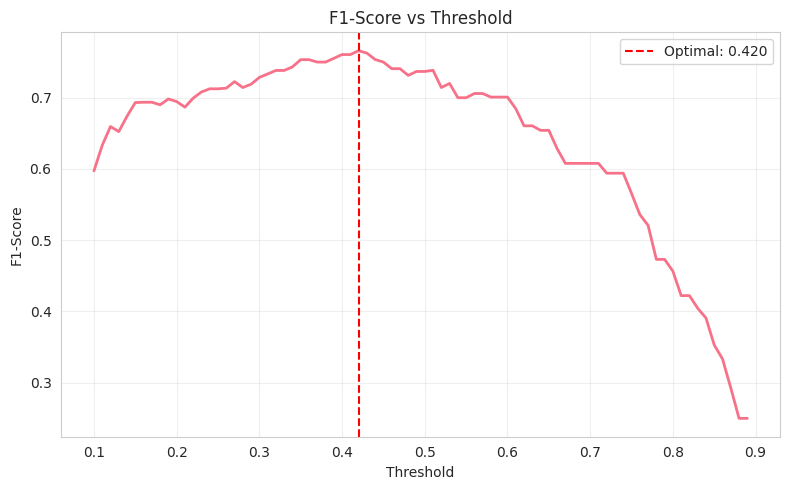

In [183]:
# Visualize F1-score across all thresholds
plt.figure(figsize=(8, 5))
plt.plot(test_thresholds, f1_scores, linewidth=2)
plt.axvline(optimal_threshold, color='red', linestyle='--',
            label=f'Optimal: {optimal_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score vs Threshold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [184]:
# Compare default vs optimal threshold
y_pred_optimal = (y_proba >= optimal_threshold).astype(int)

print("Default Threshold (0.5):")
print(f"  Precision: {precision_score(y_test, y_pred):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred):.4f}")
print(f"  F1-Score:  {f1_score(y_test, y_pred):.4f}")

print("\nOptimal Threshold:")
print(f"  Precision: {precision_score(y_test, y_pred_optimal):.4f}")
print(f"  Recall:    {recall_score(y_test, y_pred_optimal):.4f}")
print(f"  F1-Score:  {f1_score(y_test, y_pred_optimal):.4f}")


Default Threshold (0.5):
  Precision: 0.7656
  Recall:    0.7101
  F1-Score:  0.7368

Optimal Threshold:
  Precision: 0.7500
  Recall:    0.7826
  F1-Score:  0.7660


## 8. ROC Curve and AUC

ROC (Receiver Operating Characteristic) curve shows the trade-off between True Positive Rate (Recall) and False Positive Rate at different thresholds.

**AUC (Area Under Curve)**: Measures overall model performance. Higher is better (max = 1.0).


In [185]:
# Calculate ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)

# Calculate AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

print(f"AUC-ROC Score: {roc_auc:.4f}")
print(f"Interpretation: {'Excellent' if roc_auc > 0.9 else 'Good' if roc_auc > 0.8 else 'Fair' if roc_auc > 0.7 else 'Poor'}")


AUC-ROC Score: 0.8527
Interpretation: Good


In [187]:
df_roc_metrics = pd.DataFrame({
    'False Positive Rate': fpr,
    'True Positive Rate': tpr,
    'Thresholds': thresholds_roc
})

print("ROC Curve Metrics DataFrame:")
df_roc_metrics.tail()

ROC Curve Metrics DataFrame:


,False Positive Rate,True Positive Rate,Thresholds
55,0.900000,0.985507,0.083459
56,0.918182,0.985507,0.080579
57,0.927273,0.985507,0.080418
58,0.927273,1.000000,0.080245
59,1.000000,1.000000,0.012875


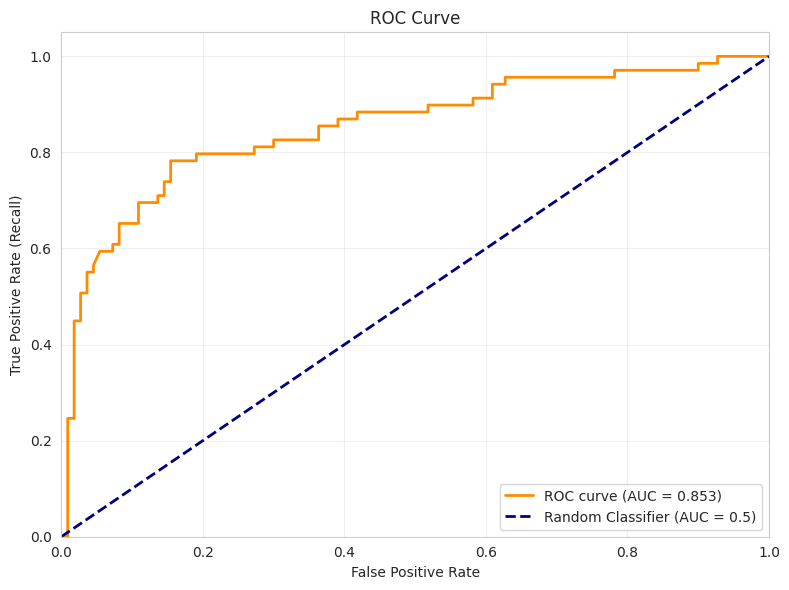

In [69]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2,
         linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 9. Precision-Recall Curve

Precision-Recall curve is especially useful for imbalanced datasets. It shows the trade-off between precision and recall.

**Edge Case**: When classes are highly imbalanced, PR curve is more informative than ROC curve.


In [188]:
# Calculate Precision-Recall curve
precision_vals, recall_vals, thresholds_pr = precision_recall_curve(y_test, y_proba)

# Calculate AUC for PR curve
pr_auc = auc(recall_vals, precision_vals)

print(f"AUC-PR Score: {pr_auc:.4f}")


AUC-PR Score: 0.7862


In [189]:
df_pr_metrics = pd.DataFrame({
    'Precision': precision_vals[:-1],
    'Recall': recall_vals[:-1],
    'Thresholds': thresholds_pr
})

print("PR Curve Metrics DataFrame:")
df_pr_metrics.tail()

PR Curve Metrics DataFrame:


,Precision,Recall,Thresholds
157,0.800000,0.057971,0.955466
158,0.750000,0.043478,0.956566
159,0.666667,0.028986,0.956790
160,0.500000,0.014493,0.961637
161,0.000000,0.000000,0.974532


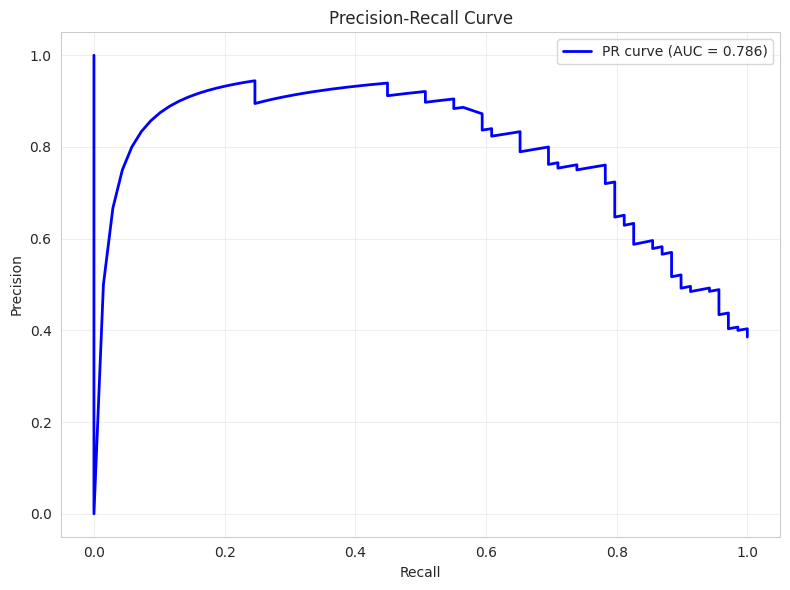

In [190]:
# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, color='blue', lw=2,
         label=f'PR curve (AUC = {pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 10. Cost Curves

Cost curves help visualize the cost of misclassification at different thresholds. Useful when false positives and false negatives have different costs.

**Edge Case**: In medical diagnosis, false negatives (missing a disease) may be much costlier than false positives.


In [191]:
# Define cost of false positives and false negatives
# Example: Missing a survivor (FN) costs 2, false alarm (FP) costs 1
cost_fp = 1  # Cost of false positive
cost_fn = 2  # Cost of false negative

# Calculate costs at different thresholds
thresholds_cost = np.arange(0.1, 0.9, 0.01)
total_costs = []

for thresh in thresholds_cost:
    y_pred_thresh = (y_proba >= thresh).astype(int)
    cm_thresh = confusion_matrix(y_test, y_pred_thresh)

    # Extract components (assuming binary classification)
    tn, fp, fn, tp = cm_thresh.ravel()

    # Calculate total cost
    total_cost = (fp * cost_fp) + (fn * cost_fn)
    total_costs.append(total_cost)


In [194]:
# Find threshold with minimum cost
optimal_cost_idx = np.argmin(total_costs)
optimal_cost_threshold = thresholds_cost[optimal_cost_idx]
min_cost = total_costs[optimal_cost_idx]

print(f"Optimal threshold (min cost): {optimal_cost_threshold:.3f}")
print(f"Minimum total cost: {min_cost}")


Optimal threshold (min cost): 0.420
Minimum total cost: 48


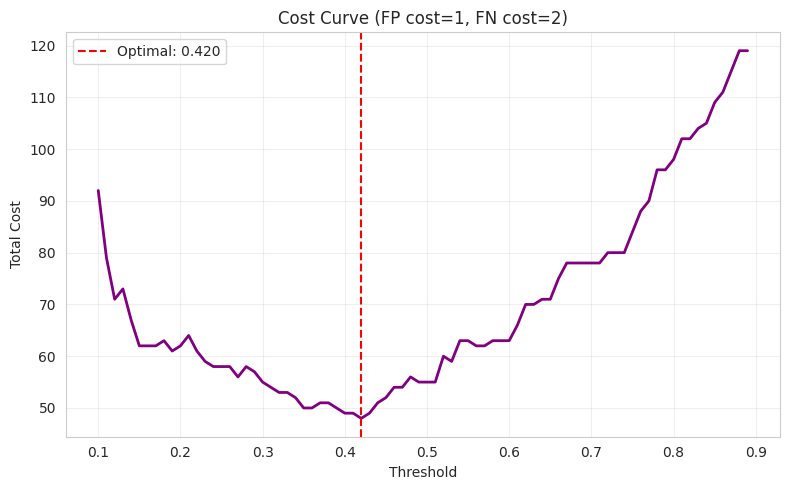

In [193]:
# Plot cost curve
plt.figure(figsize=(8, 5))
plt.plot(thresholds_cost, total_costs, linewidth=2, color='purple')
plt.axvline(optimal_cost_threshold, color='red', linestyle='--',
            label=f'Optimal: {optimal_cost_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('Total Cost')
plt.title(f'Cost Curve (FP cost={cost_fp}, FN cost={cost_fn})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 10.1 Comparing Different Cost Scenarios

Let's see how different cost ratios affect the optimal threshold.


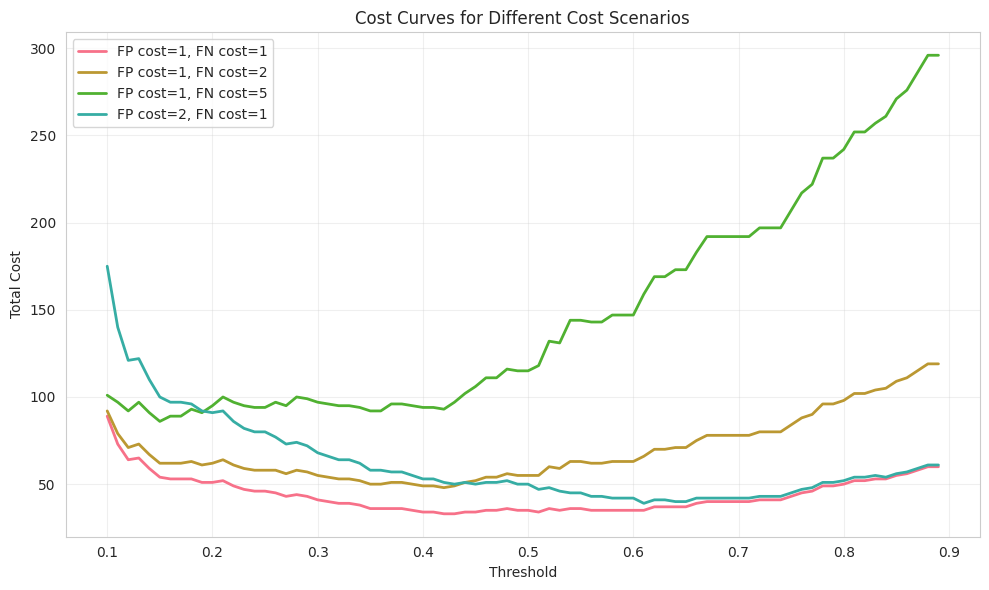

In [75]:
# Test different cost scenarios
cost_scenarios = [
    (1, 1),   # Equal costs
    (1, 2),   # FN costs 2x more
    (1, 5),   # FN costs 5x more
    (2, 1)    # FP costs 2x more
]

fig, ax = plt.subplots(figsize=(10, 6))

for cost_fp, cost_fn in cost_scenarios:
    costs = []
    for thresh in thresholds_cost:
        y_pred_thresh = (y_proba >= thresh).astype(int)
        cm_thresh = confusion_matrix(y_test, y_pred_thresh)
        tn, fp, fn, tp = cm_thresh.ravel()
        costs.append((fp * cost_fp) + (fn * cost_fn))

    ax.plot(thresholds_cost, costs, linewidth=2,
            label=f'FP cost={cost_fp}, FN cost={cost_fn}')

ax.set_xlabel('Threshold')
ax.set_ylabel('Total Cost')
ax.set_title('Cost Curves for Different Cost Scenarios')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## 11. Handling Imbalanced Data - Fraud Detection Example

In BFSI (Banking, Financial Services, and Insurance), fraud detection is a classic imbalanced problem. Typically, only 1-2% of transactions are fraudulent (90:10 or even 99:1 ratio).

**Critical Edge Case**: With 90% legitimate transactions and 10% fraud, a naive model predicting "always legitimate" gets 90% accuracy but catches ZERO fraud cases - a disaster for banks!

**Business Impact**: Missing fraud (False Negatives) costs millions, while false alarms (False Positives) just annoy customers.


### 11.1 Load Fraud Detection Dataset (Interpretable Features)

We'll use a **Fraud Detection** dataset with **interpretable features** that students can understand:
- `income`: Customer income
- `customer_age`: Customer age
- `credit_risk_score`: Credit risk assessment
- `employment_status`: Employment status (categorical)
- `housing_status`: Housing status (categorical)
- `payment_type`: Payment method (categorical)
- `proposed_credit_limit`: Proposed credit limit
- `prev_address_months_count`: Months at previous address
- `current_address_months_count`: Months at current address
- And many more interpretable features!

**Target**: `fraud_bool` (0=legitimate, 1=fraud)

This is perfect for teaching - all features have clear meanings!


In [195]:
# Load Fraud Detection dataset
df_fraud = pd.read_csv('Base.csv')

print(f"Dataset loaded! Shape: {df_fraud.shape}")
print(f"\nDataset Info:")
print(df_fraud.info())

# Display interpretable features
interpretable_features = ['income', 'customer_age', 'credit_risk_score',
                         'employment_status', 'housing_status', 'payment_type',
                         'proposed_credit_limit', 'fraud_bool']
available_features = [f for f in interpretable_features if f in df_fraud.columns]
print(f"\n✓ Found {len(available_features)} interpretable features:")
for feat in available_features:
    print(f"  - {feat}")

print(f"\nTarget: 'fraud_bool' (0=legitimate, 1=fraud)")
df_fraud.head()

Dataset loaded! Shape: (1000000, 32)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null 

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


In [199]:
# Check for missing values
print("Missing values per column:")
missing = df_fraud.isna().sum()
print(missing[missing > 0] if missing.sum() > 0 else "✓ No missing values!")

df= df[df.notna()].reset_index(drop=True)
# Check original class distribution
target_col = 'fraud_bool'
class_dist_original = df_fraud[target_col].value_counts()
print(f"\nOriginal Dataset - Class Distribution:")
print(class_dist_original)
print(f"\nOriginal Imbalance Ratio: {class_dist_original.iloc[0] / class_dist_original.iloc[1]:.1f}:1")
print(f"Fraud Rate: {class_dist_original.iloc[1] / len(df_fraud):.2%}")

Missing values per column:
✓ No missing values!

Original Dataset - Class Distribution:
fraud_bool
0    988971
1     11029
Name: count, dtype: int64

Original Imbalance Ratio: 89.7:1
Fraud Rate: 1.10%


In [198]:
11029/ (11029+988971)

0.011029

In [200]:
# Prepare features and target
# Select all features except target
feature_cols = [col for col in df_fraud.columns if col != target_col]
print(f"Selected {len(feature_cols)} features (excluding target)")

# Handle categorical features (encode them)
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
categorical_cols = df_fraud[feature_cols].select_dtypes(include=['object']).columns.tolist()
print(f"\nCategorical features to encode: {categorical_cols}")

# Create a copy for processing
df_fraud_processed = df_fraud.copy()




Selected 31 features (excluding target)

Categorical features to encode: ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os']


In [201]:
print("Before encoding:")
print(df_fraud_processed[categorical_cols[0]].unique())
# Encode categorical features
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_fraud_processed[col] = le.fit_transform(df_fraud_processed[col].astype(str))
    label_encoders[col] = le
    print(f"  Encoded '{col}': {len(le.classes_)} unique values")
print("After encoding:")
print(df_fraud_processed[categorical_cols[0]].unique())


Before encoding:
['AA' 'AD' 'AB' 'AC' 'AE']
  Encoded 'payment_type': 5 unique values
  Encoded 'employment_status': 7 unique values
  Encoded 'housing_status': 7 unique values
  Encoded 'source': 2 unique values
  Encoded 'device_os': 5 unique values
After encoding:
[0 3 1 2 4]


In [202]:
# Prepare X and y
X_fraud = df_fraud_processed[feature_cols].copy()
y_fraud = df_fraud_processed[target_col].copy()

print(f"\n✓ Data prepared: X shape {X_fraud.shape}, y shape {y_fraud.shape}")


✓ Data prepared: X shape (1000000, 31), y shape (1000000,)


In [203]:
# Sample to create 90:10 ratio for demonstration
np.random.seed(42)

# Get all fraud cases (minority class)
fraud_cases = df_fraud_processed[df_fraud_processed[target_col] == 1]
n_fraud = len(fraud_cases)
print(f"Total fraud cases: {n_fraud:,}")

# Sample legitimate cases to create 90:10 ratio
legitimate_cases = df_fraud_processed[df_fraud_processed[target_col] == 0]
n_legitimate_needed = n_fraud * 9  # 9x more for 90:10 ratio
n_legitimate_available = len(legitimate_cases)

if n_legitimate_needed <= n_legitimate_available:
    legitimate_sample = legitimate_cases.sample(n=n_legitimate_needed, random_state=42)
    print(f"Sampled {n_legitimate_needed:,} legitimate cases (90:10 ratio)")
else:
    # If we don't have enough, use all available
    legitimate_sample = legitimate_cases
    print(f"Using all {n_legitimate_available:,} available legitimate cases")
    print(f"Actual ratio will be: {len(legitimate_sample) / n_fraud:.1f}:1")

# Combine and shuffle
df_fraud_sample = pd.concat([legitimate_sample, fraud_cases]).sample(
    frac=1, random_state=42
).reset_index(drop=True)

# Update X and y with sampled data
X_fraud = df_fraud_sample[feature_cols].copy()
y_fraud = df_fraud_sample[target_col].copy()

# Show new distribution
print("\nSampled Dataset - Class Distribution:")
print(y_fraud.value_counts())
print(f"\nNew Imbalance Ratio: {y_fraud.value_counts()[0] / y_fraud.value_counts()[1]:.1f}:1")
print(f"Fraud Rate: {y_fraud.value_counts()[1] / len(y_fraud):.2%}")
print(f"\n✓ Ready for modeling! Total samples: {len(X_fraud):,}")

Total fraud cases: 11,029
Sampled 99,261 legitimate cases (90:10 ratio)

Sampled Dataset - Class Distribution:
fraud_bool
0    99261
1    11029
Name: count, dtype: int64

New Imbalance Ratio: 9.0:1
Fraud Rate: 10.00%

✓ Ready for modeling! Total samples: 110,290


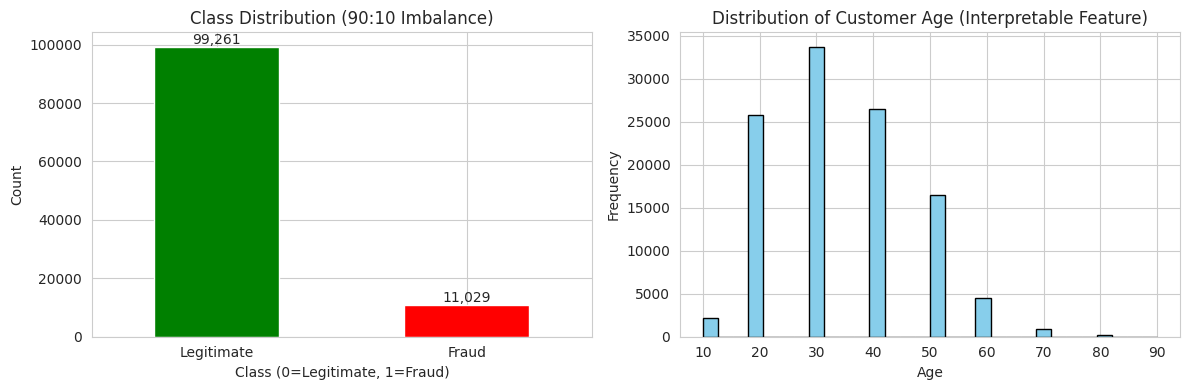


✓ Dataset ready with interpretable features!
   Features like income, customer_age, credit_risk_score are easy to understand!
   Total samples: 110,290
   Total features: 31


In [204]:
# Visualize class distribution and sample interpretable features
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Class distribution
y_fraud.value_counts().plot(kind='bar', ax=axes[0], color=['green', 'red'])
axes[0].set_title('Class Distribution (90:10 Imbalance)')
axes[0].set_xlabel('Class (0=Legitimate, 1=Fraud)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['Legitimate', 'Fraud'], rotation=0)
for i, v in enumerate(y_fraud.value_counts()):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom')

# Sample interpretable feature (customer_age or income distribution)
if 'customer_age' in X_fraud.columns:
    X_fraud['customer_age'].hist(bins=30, ax=axes[1], color='skyblue', edgecolor='black')
    axes[1].set_title('Distribution of Customer Age (Interpretable Feature)')
    axes[1].set_xlabel('Age')
    axes[1].set_ylabel('Frequency')
elif 'income' in X_fraud.columns:
    X_fraud['income'].hist(bins=50, ax=axes[1], color='skyblue', edgecolor='black')
    axes[1].set_title('Distribution of Income (Interpretable Feature)')
    axes[1].set_xlabel('Income')
    axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("\n✓ Dataset ready with interpretable features!")
print(f"   Features like income, customer_age, credit_risk_score are easy to understand!")
print(f"   Total samples: {len(X_fraud):,}")
print(f"   Total features: {len(X_fraud.columns)}")


### 11.2 Train Model on Imbalanced Data (Baseline)

First, let's see what happens with a standard model on this 90:10 imbalanced data. This demonstrates why handling imbalance is critical!

**What to expect**: The model will likely favor the majority class (legitimate transactions) and miss most fraud cases.


In [205]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split with stratification to maintain class distribution
X_fraud_train, X_fraud_test, y_fraud_train, y_fraud_test = train_test_split(
    X_fraud, y_fraud, test_size=0.2, random_state=42, stratify=y_fraud
)

print(f"Training set: {X_fraud_train.shape[0]:,} samples")
print(f"Test set: {X_fraud_test.shape[0]:,} samples")
print(f"\nTraining class distribution:")
print(y_fraud_train.value_counts())
print(f"\nTest class distribution:")
print(y_fraud_test.value_counts())

# Scale features (important for logistic regression)
scaler = StandardScaler()
X_fraud_train_scaled = scaler.fit_transform(X_fraud_train)
X_fraud_test_scaled = scaler.transform(X_fraud_test)

print(f"\n✓ Data split and scaled! Features: {X_fraud_train.shape[1]}")


Training set: 88,232 samples
Test set: 22,058 samples

Training class distribution:
fraud_bool
0    79409
1     8823
Name: count, dtype: int64

Test class distribution:
fraud_bool
0    19852
1     2206
Name: count, dtype: int64

✓ Data split and scaled! Features: 31


In [206]:
# Train standard model WITHOUT class weights (baseline)
model_fraud_standard = LogisticRegression(random_state=42, max_iter=1000)
model_fraud_standard.fit(X_fraud_train_scaled, y_fraud_train)

# Get predictions
y_fraud_proba = model_fraud_standard.predict_proba(X_fraud_test_scaled)[:, 1]
y_fraud_pred = model_fraud_standard.predict(X_fraud_test_scaled)

print("Standard Model (No Class Weights) - Results:")
print(f"  Accuracy:  {accuracy_score(y_fraud_test, y_fraud_pred):.4f}")
print(f"  Precision: {precision_score(y_fraud_test, y_fraud_pred):.4f}")
print(f"  Recall:    {recall_score(y_fraud_test, y_fraud_pred):.4f}  ⚠️  This will be VERY LOW!")
print(f"  F1-Score:  {f1_score(y_fraud_test, y_fraud_pred):.4f}")

# Show confusion matrix
cm_standard = confusion_matrix(y_fraud_test, y_fraud_pred)
print(f"\nConfusion Matrix:")
print(f"  Legitimate correctly identified (TN): {cm_standard[0,0]:,}")
print(f"  False Alarms (FP): {cm_standard[0,1]:,}")
print(f"  MISSED FRAUD (FN): {cm_standard[1,0]:,}  <-- CRITICAL!")
print(f"  Fraud caught (TP): {cm_standard[1,1]:,}")


Standard Model (No Class Weights) - Results:
  Accuracy:  0.9118
  Precision: 0.6529
  Recall:    0.2516  ⚠️  This will be VERY LOW!
  F1-Score:  0.3632

Confusion Matrix:
  Legitimate correctly identified (TN): 19,557
  False Alarms (FP): 295
  MISSED FRAUD (FN): 1,651  <-- CRITICAL!
  Fraud caught (TP): 555


### 11.3 Method 1: Use Class Weights

Class weights automatically adjust the model to penalize misclassifying fraud (minority class) more heavily.

**How it works**: With 90:10 imbalance, fraud class gets 9x more weight, making the model pay more attention to catching fraud cases.

**Advantage**: No need to modify the dataset, just change model parameters.


In [207]:
# Train model WITH balanced class weights
model_fraud_balanced = LogisticRegression(
    random_state=42,
    max_iter=1000,
    class_weight='balanced'  # Automatically balances class weights
)
model_fraud_balanced.fit(X_fraud_train_scaled, y_fraud_train)



LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [208]:
# Get predictions
y_fraud_proba_balanced = model_fraud_balanced.predict_proba(X_fraud_test_scaled)[:, 1]
y_fraud_pred_balanced = model_fraud_balanced.predict(X_fraud_test_scaled)

print("Balanced Class Weights Model - Results:")
print(f"  Accuracy:  {accuracy_score(y_fraud_test, y_fraud_pred_balanced):.4f}")
print(f"  Precision: {precision_score(y_fraud_test, y_fraud_pred_balanced):.4f}")
print(f"  Recall:    {recall_score(y_fraud_test, y_fraud_pred_balanced):.4f}  ✅ Much Better!")
print(f"  F1-Score:  {f1_score(y_fraud_test, y_fraud_pred_balanced):.4f}")



Balanced Class Weights Model - Results:
  Accuracy:  0.7902
  Precision: 0.2947
  Recall:    0.7879  ✅ Much Better!
  F1-Score:  0.4289


In [209]:
# Compare with standard model
print(f"\n📊 Comparison:")
print(f"  Recall improved: {recall_score(y_fraud_test, y_fraud_pred_balanced) - recall_score(y_fraud_test, y_fraud_pred):.4f}")
print(f"  💡 Key Insight: Recall (catching fraud) improved significantly!")
print(f"     In fraud detection, high recall is critical - we can't miss fraud!")



📊 Comparison:
  Recall improved: 0.5363
  💡 Key Insight: Recall (catching fraud) improved significantly!
     In fraud detection, high recall is critical - we can't miss fraud!


### 11.4 Method 2: Oversampling (Resampling)

We can oversample fraud cases to balance the dataset from 90:10 to 50:50. This creates more fraud examples for the model to learn from.

**How it works**: Duplicate fraud cases until we have equal numbers of legitimate and fraud transactions.

**Note**: This increases training data size, which may slow down training slightly.


In [210]:
# Oversample fraud cases to balance the dataset
from sklearn.utils import resample

# Combine X and y for resampling
df_fraud_train = pd.DataFrame(X_fraud_train_scaled, columns=X_fraud.columns)
df_fraud_train['target'] = y_fraud_train.values

# Separate classes
legitimate = df_fraud_train[df_fraud_train['target'] == 0]
fraud = df_fraud_train[df_fraud_train['target'] == 1]

print(f"Before oversampling:")
print(f"  Legitimate: {len(legitimate):,}")
print(f"  Fraud: {len(fraud):,}")



Before oversampling:
  Legitimate: 79,409
  Fraud: 8,823


In [211]:
# Upsample fraud to match legitimate
fraud_upsampled = resample(fraud,
                           replace=True,  # Sample with replacement
                           n_samples=len(legitimate),  # Match legitimate count
                           random_state=42)

# Combine
df_fraud_upsampled = pd.concat([legitimate, fraud_upsampled]).sample(
    frac=1, random_state=42
).reset_index(drop=True)

df_fraud_upsampled .head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,velocity_6h,...,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month,target
0,0.439436,-0.408081,0.605017,-0.927923,-1.165366,2.820780,-0.454014,0.771234,0.358265,0.629933,...,-0.670321,-0.167539,-0.087999,-0.643785,1.130624,-1.116501,-0.121734,0.0,-1.490648,0
1,-0.937044,0.282723,-0.388566,0.011257,-0.350930,-0.190205,-0.467117,-0.271288,0.294530,-0.439913,...,-0.670321,-0.167539,-0.087999,-0.307559,1.130624,-1.116501,-0.121734,0.0,0.312109,0
2,0.439436,1.199833,-0.388566,-0.181105,0.463506,-0.189411,-0.447455,-0.271288,-0.765062,-1.388826,...,-0.670321,-0.167539,-0.087999,-0.129211,0.312573,0.895655,-0.121734,0.0,1.213488,0
3,0.095316,-1.104681,-0.388566,-0.611091,0.463506,-0.188210,-0.465072,0.771234,0.615196,-0.368426,...,-0.082878,-0.167539,11.363789,3.569849,0.312573,-1.116501,-0.121734,0.0,0.312109,1
4,-1.281164,-1.180151,-0.388566,2.353548,2.092378,-0.182887,-0.494709,-0.271288,1.265491,0.936650,...,-0.670321,-0.167539,-0.087999,-0.729128,1.130624,-1.116501,-0.121734,0.0,-1.039959,0


In [212]:
# Split back to X and y
X_fraud_upsampled = df_fraud_upsampled.drop('target', axis=1).values
y_fraud_upsampled = df_fraud_upsampled['target'].values

print(f"\nAfter oversampling:")
print(f"  Legitimate: {(y_fraud_upsampled == 0).sum():,}")
print(f"  Fraud: {(y_fraud_upsampled == 1).sum():,}")
print(f"  Ratio: 50:50 ✓")



After oversampling:
  Legitimate: 79,409
  Fraud: 79,409
  Ratio: 50:50 ✓


In [213]:
# Train model on upsampled data
model_fraud_upsampled = LogisticRegression(random_state=42, max_iter=1000)
model_fraud_upsampled.fit(X_fraud_upsampled, y_fraud_upsampled)

LogisticRegression(max_iter=1000, random_state=42)

In [214]:
# Get predictions on test set
y_fraud_pred_upsampled = model_fraud_upsampled.predict(X_fraud_test_scaled)

print("Upsampled Data Model - Results:")
print(f"  Accuracy:  {accuracy_score(y_fraud_test, y_fraud_pred_upsampled):.4f}")
print(f"  Precision: {precision_score(y_fraud_test, y_fraud_pred_upsampled):.4f}")
print(f"  Recall:    {recall_score(y_fraud_test, y_fraud_pred_upsampled):.4f}  ✅ Good!")
print(f"  F1-Score:  {f1_score(y_fraud_test, y_fraud_pred_upsampled):.4f}")

Upsampled Data Model - Results:
  Accuracy:  0.7899
  Precision: 0.2944
  Recall:    0.7883  ✅ Good!
  F1-Score:  0.4287


In [215]:
# Compare all three approaches
print("=" * 70)
print("FRAUD DETECTION MODEL COMPARISON (90:10 Imbalanced Data)")
print("=" * 70)

print("\n1. Standard Model (No Handling):")
print(f"   Precision: {precision_score(y_fraud_test, y_fraud_pred):.4f}")
print(f"   Recall:    {recall_score(y_fraud_test, y_fraud_pred):.4f}  ⚠️  Very Low!")
print(f"   F1-Score:  {f1_score(y_fraud_test, y_fraud_pred):.4f}")

print("\n2. Balanced Class Weights:")
print(f"   Precision: {precision_score(y_fraud_test, y_fraud_pred_balanced):.4f}")
print(f"   Recall:    {recall_score(y_fraud_test, y_fraud_pred_balanced):.4f}  ✅ Much Better!")
print(f"   F1-Score:  {f1_score(y_fraud_test, y_fraud_pred_balanced):.4f}")

print("\n3. Upsampled Data:")
print(f"   Precision: {precision_score(y_fraud_test, y_fraud_pred_upsampled):.4f}")
print(f"   Recall:    {recall_score(y_fraud_test, y_fraud_pred_upsampled):.4f}  ✅ Good!")
print(f"   F1-Score:  {f1_score(y_fraud_test, y_fraud_pred_upsampled):.4f}")

print("\n💡 Business Impact:")
print("   - High Recall = Catch more fraud (save money)")
print("   - Lower Precision = More false alarms (customer annoyance)")
print("   - In fraud detection, RECALL is often more important than precision!")


FRAUD DETECTION MODEL COMPARISON (90:10 Imbalanced Data)

1. Standard Model (No Handling):
   Precision: 0.6529
   Recall:    0.2516  ⚠️  Very Low!
   F1-Score:  0.3632

2. Balanced Class Weights:
   Precision: 0.2947
   Recall:    0.7879  ✅ Much Better!
   F1-Score:  0.4289

3. Upsampled Data:
   Precision: 0.2944
   Recall:    0.7883  ✅ Good!
   F1-Score:  0.4287

💡 Business Impact:
   - High Recall = Catch more fraud (save money)
   - Lower Precision = More false alarms (customer annoyance)
   - In fraud detection, RECALL is often more important than precision!


### 11.5 Visual Comparison: Why 90:10 Imbalance is Dangerous

Let's visualize how the standard model fails on imbalanced data and how our solutions improve fraud detection.

**Key Insight**: Notice how the standard model has very low True Positives (fraud caught) in the confusion matrix!


In [94]:
# Calculate ROC curves for all models
y_fraud_proba_upsampled = model_fraud_upsampled.predict_proba(X_fraud_test_scaled)[:, 1]

fpr_std, tpr_std, _ = roc_curve(y_fraud_test, y_fraud_proba)
fpr_bal, tpr_bal, _ = roc_curve(y_fraud_test, y_fraud_proba_balanced)
fpr_up, tpr_up, _ = roc_curve(y_fraud_test, y_fraud_proba_upsampled)

# Calculate AUCs
auc_std = roc_auc_score(y_fraud_test, y_fraud_proba)
auc_bal = roc_auc_score(y_fraud_test, y_fraud_proba_balanced)
auc_up = roc_auc_score(y_fraud_test, y_fraud_proba_upsampled)

print("AUC-ROC Scores:")
print(f"  Standard: {auc_std:.4f}")
print(f"  Balanced Weights: {auc_bal:.4f}")
print(f"  Upsampled: {auc_up:.4f}")


AUC-ROC Scores:
  Standard: 0.8657
  Balanced Weights: 0.8664
  Upsampled: 0.8664


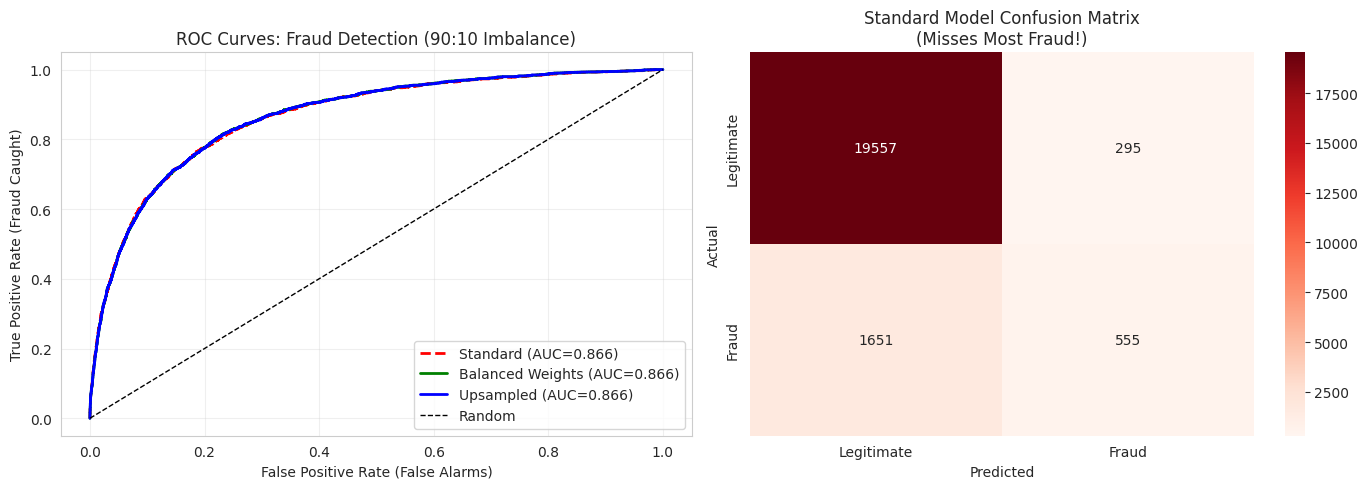


⚠️  Notice: Standard model has very low True Positives (fraud caught)
   This is why handling imbalanced data is CRITICAL in fraud detection!


In [95]:
# Visualize ROC curves and confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curves
axes[0].plot(fpr_std, tpr_std, label=f'Standard (AUC={auc_std:.3f})',
             linewidth=2, color='red', linestyle='--')
axes[0].plot(fpr_bal, tpr_bal, label=f'Balanced Weights (AUC={auc_bal:.3f})',
             linewidth=2, color='green')
axes[0].plot(fpr_up, tpr_up, label=f'Upsampled (AUC={auc_up:.3f})',
             linewidth=2, color='blue')
axes[0].plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)
axes[0].set_xlabel('False Positive Rate (False Alarms)')
axes[0].set_ylabel('True Positive Rate (Fraud Caught)')
axes[0].set_title('ROC Curves: Fraud Detection (90:10 Imbalance)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Confusion Matrix for Standard Model
cm_std = confusion_matrix(y_fraud_test, y_fraud_pred)
sns.heatmap(cm_std, annot=True, fmt='d', cmap='Reds', ax=axes[1],
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'])
axes[1].set_title('Standard Model Confusion Matrix\n(Misses Most Fraud!)')
axes[1].set_ylabel('Actual')
axes[1].set_xlabel('Predicted')

plt.tight_layout()
plt.show()

print("\n⚠️  Notice: Standard model has very low True Positives (fraud caught)")
print("   This is why handling imbalanced data is CRITICAL in fraud detection!")


## 12. Advanced Model Evaluation: Lift Charts, Gain Charts, and KS Statistics

In fraud detection and marketing analytics, we need to understand **model performance at different deciles** of the population. These metrics help answer critical business questions:

- **Lift Chart**: "How much better is our model compared to random selection?"
- **Gain Chart**: "What percentage of fraud cases can we catch by targeting the top X% of high-risk customers?"
- **KS Statistic**: "What's the maximum separation between fraud and legitimate cases?"

**Business Context**: In fraud detection, we can't investigate all transactions. We need to prioritize the riskiest ones. These charts show us exactly how to do that!


### 12.1 Understanding Decile Analysis

We'll divide our test set into 10 equal groups (deciles) based on predicted fraud probability, from highest risk (Decile 1) to lowest risk (Decile 10).

**Key Insight**: If our model is good, most fraud cases should be in the top deciles (high predicted probability).


In [96]:
# Use the balanced class weights model for decile analysis
# This model showed better recall (catches more fraud)
y_proba_fraud = y_fraud_proba_balanced.copy()
y_actual_fraud = y_fraud_test.copy()

# Create DataFrame with predictions and actuals
df_decile = pd.DataFrame({
    'actual': y_actual_fraud.values,
    'predicted_prob': y_proba_fraud
})

# Sort by predicted probability (descending - highest risk first)
df_decile = df_decile.sort_values('predicted_prob', ascending=False).reset_index(drop=True)

# Assign decile ranks (1 = highest risk, 10 = lowest risk)
n_samples = len(df_decile)
decile_size = n_samples // 10
df_decile['decile'] = (df_decile.index // decile_size) + 1
df_decile['decile'] = df_decile['decile'].clip(upper=10)  # Ensure last decile is 10

print(f"Total samples: {n_samples:,}")
print(f"Decile size: {decile_size:,} samples per decile")
print(f"\nFirst few rows (highest risk):")


df_decile.head(10)


Total samples: 22,058
Decile size: 2,205 samples per decile

First few rows (highest risk):


,actual,predicted_prob,decile
0,1,0.996252,1
1,1,0.993966,1
2,1,0.993354,1
3,0,0.993091,1
4,1,0.992866,1
5,1,0.992627,1
6,1,0.992447,1
7,1,0.992053,1
8,1,0.991745,1
9,1,0.990720,1


In [121]:
df_decile.to_csv('decile_summary.csv')

In [97]:
# Calculate metrics for each decile
decile_stats = []

for decile in range(1, 11):
    decile_data = df_decile[df_decile['decile'] == decile]

    n_total = len(decile_data)
    n_fraud = decile_data['actual'].sum()
    fraud_rate = n_fraud / n_total if n_total > 0 else 0
    avg_prob = decile_data['predicted_prob'].mean()

    decile_stats.append({
        'decile': decile,
        'n_total': n_total,
        'n_fraud': n_fraud,
        'fraud_rate': fraud_rate,
        'avg_predicted_prob': avg_prob,
        'cumulative_fraud': df_decile[df_decile['decile'] <= decile]['actual'].sum(),
        'cumulative_pct': (df_decile[df_decile['decile'] <= decile]['actual'].sum() /
                          df_decile['actual'].sum()) * 100 if df_decile['actual'].sum() > 0 else 0
    })

df_decile_stats = pd.DataFrame(decile_stats)

# Calculate overall fraud rate (baseline)
overall_fraud_rate = df_decile['actual'].mean()

# Calculate lift (how many times better than random)
df_decile_stats['lift'] = df_decile_stats['fraud_rate'] / overall_fraud_rate

print("Decile Analysis Summary:")
print("=" * 80)

print(f"\nOverall fraud rate (baseline): {overall_fraud_rate:.4f} ({overall_fraud_rate*100:.2f}%)")
df_decile_stats.round(4)



Decile Analysis Summary:

Overall fraud rate (baseline): 0.1000 (10.00%)


,decile,n_total,n_fraud,fraud_rate,avg_predicted_prob,cumulative_fraud,cumulative_pct,lift
0,1,2205,1090,0.4943,0.8763,1090,49.4107,4.9429
1,2,2205,467,0.2118,0.6886,1557,70.5802,2.1177
2,3,2205,255,0.1156,0.5253,1812,82.1396,1.1564
3,4,2205,143,0.0649,0.3995,1955,88.6219,0.6485
4,5,2205,81,0.0367,0.2991,2036,92.2937,0.3673
5,6,2205,68,0.0308,0.2214,2104,95.3762,0.3084
6,7,2205,39,0.0177,0.1575,2143,97.1442,0.1769
7,8,2205,28,0.0127,0.1081,2171,98.4134,0.1270
8,9,2205,21,0.0095,0.0671,2192,99.3654,0.0952
9,10,2213,14,0.0063,0.0278,2206,100.0000,0.0633


### 12.2 Lift Chart

**Lift** measures how much better our model performs compared to random selection.

- **Lift = 1.0**: Model performs same as random (no improvement)
- **Lift > 1.0**: Model is better than random (higher is better)
- **Lift < 1.0**: Model is worse than random

**Business Interpretation**: A lift of 3.0 in Decile 1 means fraud rate is 3x higher in the top 10% of high-risk transactions compared to the overall fraud rate.


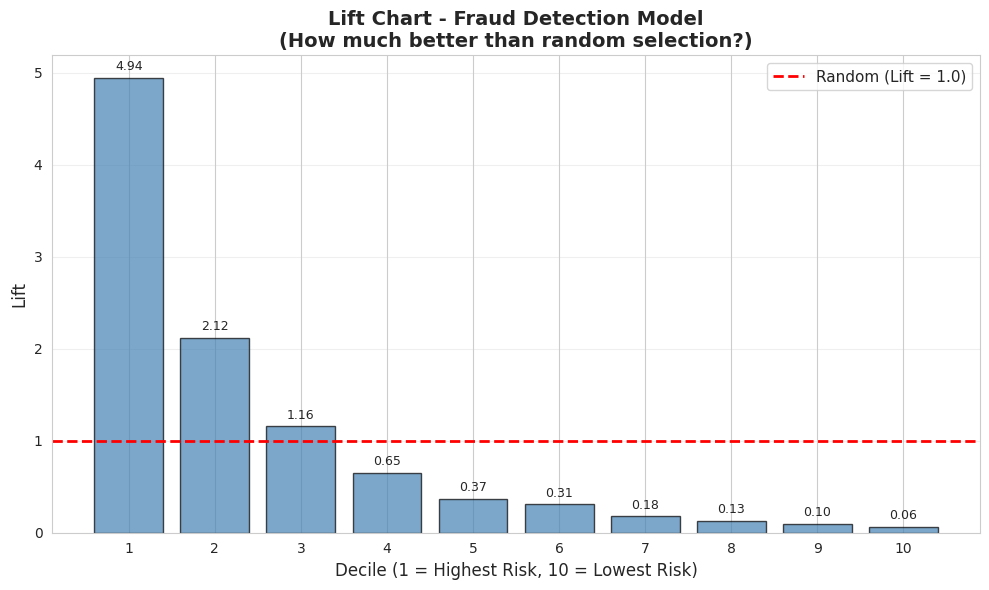

💡 Key Insights from Lift Chart:
   - Top Decile (Decile 1) has lift of 4.94x
     This means fraud rate is 4.9x higher than average!
   - Bottom Decile (Decile 10) has lift of 0.06x
   - Good models show high lift in top deciles and low lift in bottom deciles


In [98]:
# Create Lift Chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot lift for each decile
ax.bar(df_decile_stats['decile'], df_decile_stats['lift'],
       color='steelblue', edgecolor='black', alpha=0.7)

# Add reference line at lift = 1.0 (random performance)
ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2,
           label='Random (Lift = 1.0)')

# Customize plot
ax.set_xlabel('Decile (1 = Highest Risk, 10 = Lowest Risk)', fontsize=12)
ax.set_ylabel('Lift', fontsize=12)
ax.set_title('Lift Chart - Fraud Detection Model\n(How much better than random selection?)',
             fontsize=14, fontweight='bold')
ax.set_xticks(range(1, 11))
ax.grid(True, alpha=0.3, axis='y')
ax.legend(fontsize=11)

# Add value labels on bars
for idx, row in df_decile_stats.iterrows():
    ax.text(row['decile'], row['lift'] + 0.05, f"{row['lift']:.2f}",
            ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print key insights
print("💡 Key Insights from Lift Chart:")
print(f"   - Top Decile (Decile 1) has lift of {df_decile_stats.iloc[0]['lift']:.2f}x")
print(f"     This means fraud rate is {df_decile_stats.iloc[0]['lift']:.1f}x higher than average!")
print(f"   - Bottom Decile (Decile 10) has lift of {df_decile_stats.iloc[9]['lift']:.2f}x")
print(f"   - Good models show high lift in top deciles and low lift in bottom deciles")


### 12.4 Kolmogorov-Smirnov (KS) Statistic

**KS Statistic** measures the maximum separation between the cumulative distribution of fraud cases and legitimate cases across all deciles.

- **KS = 0**: No separation (model is useless)
- **KS = 1**: Perfect separation (model is perfect)
- **KS > 0.4**: Good model (commonly used threshold in industry)
- **KS > 0.5**: Excellent model

**Business Interpretation**: Higher KS means the model better distinguishes between fraud and legitimate transactions.


In [99]:
def ensure_variable(name, default_func=None, error_msg=None):
    """Check if a variable exists in the globals; if not, assign using default_func or raise NameError."""
    global_vars = globals()
    if name not in global_vars:
        if default_func is not None:
            global_vars[name] = default_func()
            print(f"✓ Calculated {name}: {global_vars[name]:,}" if isinstance(global_vars[name], int) else f"✓ Calculated {name}")
        else:
            print(error_msg or f"⚠️ Warning: {name} not found.")
            raise NameError(error_msg or f"{name} not found.")
    return global_vars[name]

# Ensure required variables
df_decile = ensure_variable(
    "df_decile",
    default_func=None,
    error_msg="df_decile not found. Please run the decile analysis cell first."
)
df_decile_stats = ensure_variable(
    "df_decile_stats",
    default_func=None,
    error_msg="df_decile_stats not found. Please run the decile statistics cell first."
)
n_samples = ensure_variable(
    "n_samples",
    default_func=lambda: len(df_decile)
)
total_fraud = ensure_variable(
    "total_fraud",
    default_func=lambda: df_decile['actual'].sum()
)

✓ Calculated total_fraud


In [100]:
# Calculate additional stats columns if needed
if 'cumulative_pct_population' not in df_decile_stats.columns:
    df_decile_stats['cumulative_pct_population'] = df_decile_stats['decile'] * 10
    print("✓ Calculated cumulative_pct_population")

if 'cumulative_pct_fraud' not in df_decile_stats.columns:
    df_decile_stats['cumulative_pct_fraud'] = (
        df_decile_stats['cumulative_fraud'] / total_fraud * 100
    )
    print("✓ Calculated cumulative_pct_fraud")

if 'cumulative_pct_legitimate' not in df_decile_stats.columns:
    # Cumulative legitimate = (cumulative population - cumulative fraud) / total legitimate * 100
    df_decile_stats['cumulative_pct_legitimate'] = (
        (df_decile_stats['cumulative_pct_population']/100 * n_samples - df_decile_stats['cumulative_fraud'])
        / (n_samples - total_fraud) * 100
    )
    print("✓ Calculated cumulative_pct_legitimate")

# Compute KS
df_decile_stats['ks'] = (
    df_decile_stats['cumulative_pct_fraud'] - df_decile_stats['cumulative_pct_legitimate']
)

# Output
print("\n" + "=" * 80)
print("DECILE STATISTICS WITH KS CALCULATION")
print("=" * 80)
print("\nDataFrame showing all decile metrics:")

# Build list of existing columns for display (dynamic)
potential_cols = [
    'decile', 'n_total', 'n_fraud', 'fraud_rate', 'lift',
    'cumulative_pct_population', 'cumulative_pct_fraud',
    'cumulative_pct_legitimate', 'ks'
]
display_cols = [col for col in potential_cols if col in df_decile_stats.columns]
df_decile_stats[display_cols].round(4)

✓ Calculated cumulative_pct_population
✓ Calculated cumulative_pct_fraud
✓ Calculated cumulative_pct_legitimate

DECILE STATISTICS WITH KS CALCULATION

DataFrame showing all decile metrics:


,decile,n_total,n_fraud,fraud_rate,lift,cumulative_pct_population,cumulative_pct_fraud,cumulative_pct_legitimate,ks
0,1,2205,1090,0.4943,4.9429,10,49.4107,5.6206,43.7901
1,2,2205,467,0.2118,2.1177,20,70.5802,14.3794,56.2008
2,3,2205,255,0.1156,1.1564,30,82.1396,24.2061,57.9335
3,4,2205,143,0.0649,0.6485,40,88.6219,34.5970,54.0249
4,5,2205,81,0.0367,0.3673,50,92.2937,45.3002,46.9935
5,6,2205,68,0.0308,0.3084,60,95.3762,56.0689,39.3073
6,7,2205,39,0.0177,0.1769,70,97.1442,66.9837,30.1605
7,8,2205,28,0.0127,0.1270,80,98.4134,77.9539,20.4596
8,9,2205,21,0.0095,0.0952,90,99.3654,88.9593,10.4061
9,10,2213,14,0.0063,0.0633,100,100.0000,100.0000,0.0000


In [101]:
# Find maximum KS (KS statistic)
ks_statistic = df_decile_stats['ks'].max()
ks_decile = df_decile_stats.loc[df_decile_stats['ks'].idxmax(), 'decile']

print("\n" + "=" * 80)
print("KS STATISTIC RESULTS")
print("=" * 80)
print(f"KS Statistic: {ks_statistic:.4f} ({ks_statistic:.2f}%)")
print(f"Maximum separation occurs at Decile {int(ks_decile)}")



KS STATISTIC RESULTS
KS Statistic: 57.9335 (57.93%)
Maximum separation occurs at Decile 3


In [102]:
if ks_statistic >= 0.5:
    print("Excellent (KS >= 0.5) ✅")
elif ks_statistic >= 0.4:
    print("Good (KS >= 0.4) ✅")
elif ks_statistic >= 0.3:
    print("Fair (KS >= 0.3) ⚠️")
else:
    print("Poor (KS < 0.3) ❌")

# Show the row with maximum KS for better understanding
print(f"\n📊 Decile with Maximum KS (Decile {int(ks_decile)}):")
max_ks_row = df_decile_stats.loc[df_decile_stats['ks'].idxmax()]
print(f"   Cumulative % Fraud:      {max_ks_row['cumulative_pct_fraud']:.2f}%")
print(f"   Cumulative % Legitimate:  {max_ks_row['cumulative_pct_legitimate']:.2f}%")
print(f"   KS (Difference):          {max_ks_row['ks']:.4f}")
print(f"   This is where the model best separates fraud from legitimate cases!")


Excellent (KS >= 0.5) ✅

📊 Decile with Maximum KS (Decile 3):
   Cumulative % Fraud:      82.14%
   Cumulative % Legitimate:  24.21%
   KS (Difference):          57.9335
   This is where the model best separates fraud from legitimate cases!


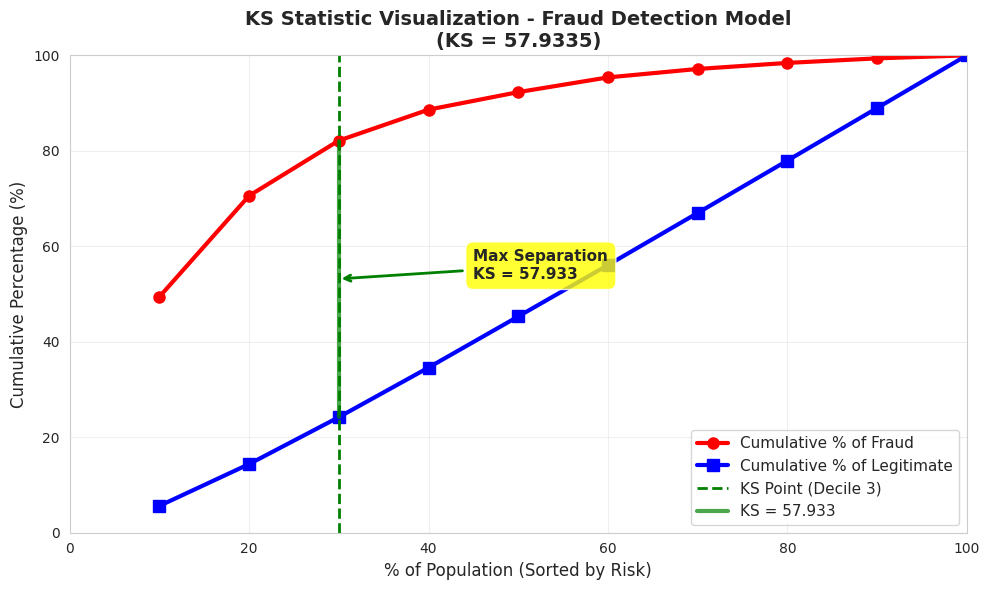


💡 Interpretation:
   - At Decile 3, there's maximum separation between fraud and legitimate
   - KS = 57.933 means the model can distinguish fraud from legitimate cases well
   - This is a key metric used in banking and fraud detection systems!


In [103]:
# Visualize KS Statistic
fig, ax = plt.subplots(figsize=(10, 6))

# Plot cumulative % of fraud
ax.plot(df_decile_stats['cumulative_pct_population'],
        df_decile_stats['cumulative_pct_fraud'],
        marker='o', linewidth=3, markersize=8, label='Cumulative % of Fraud', color='red')

# Plot cumulative % of legitimate
ax.plot(df_decile_stats['cumulative_pct_population'],
        df_decile_stats['cumulative_pct_legitimate'],
        marker='s', linewidth=3, markersize=8, label='Cumulative % of Legitimate', color='blue')

# Highlight maximum separation (KS point)
ks_idx = df_decile_stats['ks'].idxmax()
ks_x = df_decile_stats.loc[ks_idx, 'cumulative_pct_population']
ks_y_fraud = df_decile_stats.loc[ks_idx, 'cumulative_pct_fraud']
ks_y_legit = df_decile_stats.loc[ks_idx, 'cumulative_pct_legitimate']

# Draw vertical line at KS point
ax.axvline(x=ks_x, color='green', linestyle='--', linewidth=2,
           label=f'KS Point (Decile {int(df_decile_stats.loc[ks_idx, "decile"])})')

# Draw horizontal line showing KS distance
ax.plot([ks_x, ks_x], [ks_y_legit, ks_y_fraud],
        'g-', linewidth=3, alpha=0.7, label=f'KS = {ks_statistic:.3f}')

# Customize plot
ax.set_xlabel('% of Population (Sorted by Risk)', fontsize=12)
ax.set_ylabel('Cumulative Percentage (%)', fontsize=12)
ax.set_title(f'KS Statistic Visualization - Fraud Detection Model\n(KS = {ks_statistic:.4f})',
             fontsize=14, fontweight='bold')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11, loc='lower right')

# Add annotation for KS point
ax.annotate(f'Max Separation\nKS = {ks_statistic:.3f}',
            xy=(ks_x, (ks_y_fraud + ks_y_legit) / 2),
            xytext=(ks_x + 15, (ks_y_fraud + ks_y_legit) / 2),
            arrowprops=dict(arrowstyle='->', color='green', lw=2),
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.8),
            fontsize=11, fontweight='bold', ha='left')

plt.tight_layout()
plt.show()

print(f"\n💡 Interpretation:")
print(f"   - At Decile {int(ks_decile)}, there's maximum separation between fraud and legitimate")
print(f"   - KS = {ks_statistic:.3f} means the model can distinguish fraud from legitimate cases well")
print(f"   - This is a key metric used in banking and fraud detection systems!")


### 12.3 Gain Chart (Cumulative Gains)

**Gain Chart** shows the cumulative percentage of fraud cases captured by targeting the top X% of high-risk transactions.

**Business Question**: "If we investigate only the top 20% of high-risk transactions, what percentage of all fraud cases will we catch?"

**Perfect Model**: Would catch 100% of fraud in the top 10% (if fraud rate is 10%)
**Random Model**: Would catch 20% of fraud when targeting top 20% (linear line)

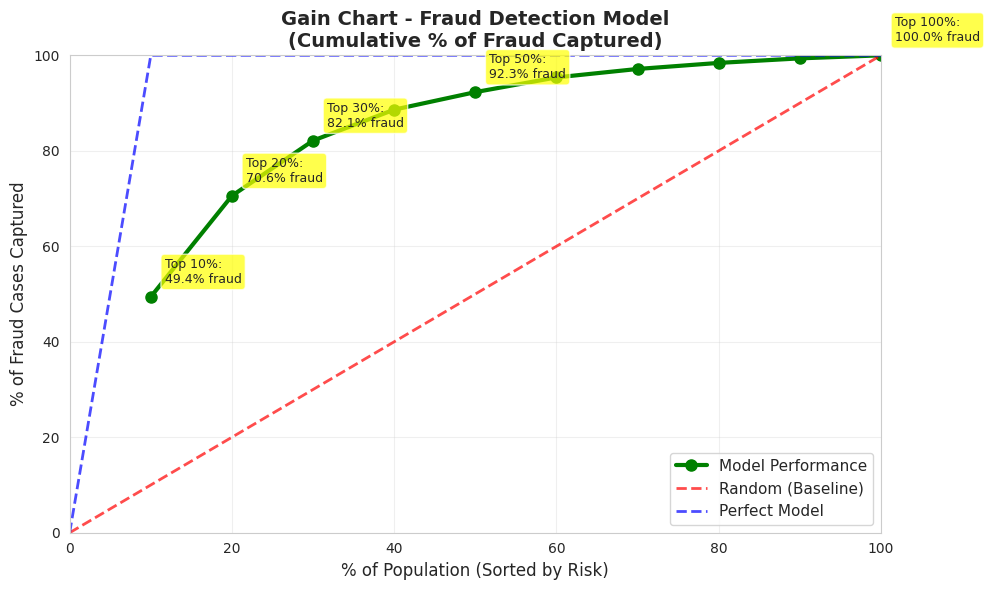

💡 Key Insights from Gain Chart:
   - By targeting top 20% of high-risk transactions, we catch 70.6% of all fraud
   - By targeting top 30% of high-risk transactions, we catch 82.1% of all fraud
   - This helps prioritize investigation resources efficiently!


In [104]:
# Prepare data for Gain Chart
# Calculate cumulative percentage of population and cumulative percentage of fraud
df_decile_stats['cumulative_pct_population'] = df_decile_stats['decile'] * 10  # Each decile is 10% of population
total_fraud = df_decile['actual'].sum()

# Calculate cumulative fraud percentage
df_decile_stats['cumulative_pct_fraud'] = (
    df_decile_stats['cumulative_fraud'] / total_fraud * 100
)

# Create Gain Chart
fig, ax = plt.subplots(figsize=(10, 6))

# Plot model performance (cumulative gain)
ax.plot(df_decile_stats['cumulative_pct_population'],
        df_decile_stats['cumulative_pct_fraud'],
        marker='o', linewidth=3, markersize=8, label='Model Performance', color='green')

# Plot random/baseline (diagonal line - 20% population = 20% fraud)
ax.plot([0, 100], [0, 100], 'r--', linewidth=2, label='Random (Baseline)', alpha=0.7)

# Plot perfect model (if we could catch all fraud in top 10%)
# For 10% fraud rate, perfect model would catch 100% fraud in top 10% of population
fraud_rate_pct = overall_fraud_rate * 100
perfect_x = [0, fraud_rate_pct, 100]
perfect_y = [0, 100, 100]
ax.plot(perfect_x, perfect_y, 'b--', linewidth=2, label='Perfect Model', alpha=0.7)

# Customize plot
ax.set_xlabel('% of Population (Sorted by Risk)', fontsize=12)
ax.set_ylabel('% of Fraud Cases Captured', fontsize=12)
ax.set_title('Gain Chart - Fraud Detection Model\n(Cumulative % of Fraud Captured)',
             fontsize=14, fontweight='bold')
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.grid(True, alpha=0.3)
ax.legend(fontsize=11, loc='lower right')

# Add annotations for key points
for idx in [0, 1, 2, 4, 9]:  # Deciles 1, 2, 3, 5, 10
    row = df_decile_stats.iloc[idx]
    ax.annotate(f"Top {row['cumulative_pct_population']:.0f}%:\n{row['cumulative_pct_fraud']:.1f}% fraud",
                xy=(row['cumulative_pct_population'], row['cumulative_pct_fraud']),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                fontsize=9, ha='left')

plt.tight_layout()
plt.show()

# Print key insights
print("💡 Key Insights from Gain Chart:")
top_20_pct_fraud = df_decile_stats[df_decile_stats['cumulative_pct_population'] == 20]['cumulative_pct_fraud'].values[0]
top_30_pct_fraud = df_decile_stats[df_decile_stats['cumulative_pct_population'] == 30]['cumulative_pct_fraud'].values[0]
print(f"   - By targeting top 20% of high-risk transactions, we catch {top_20_pct_fraud:.1f}% of all fraud")
print(f"   - By targeting top 30% of high-risk transactions, we catch {top_30_pct_fraud:.1f}% of all fraud")
print(f"   - This helps prioritize investigation resources efficiently!")


### 12.5 Combined Visualization: Lift, Gain, and KS

Let's create a comprehensive visualization showing all three metrics together for easy comparison.


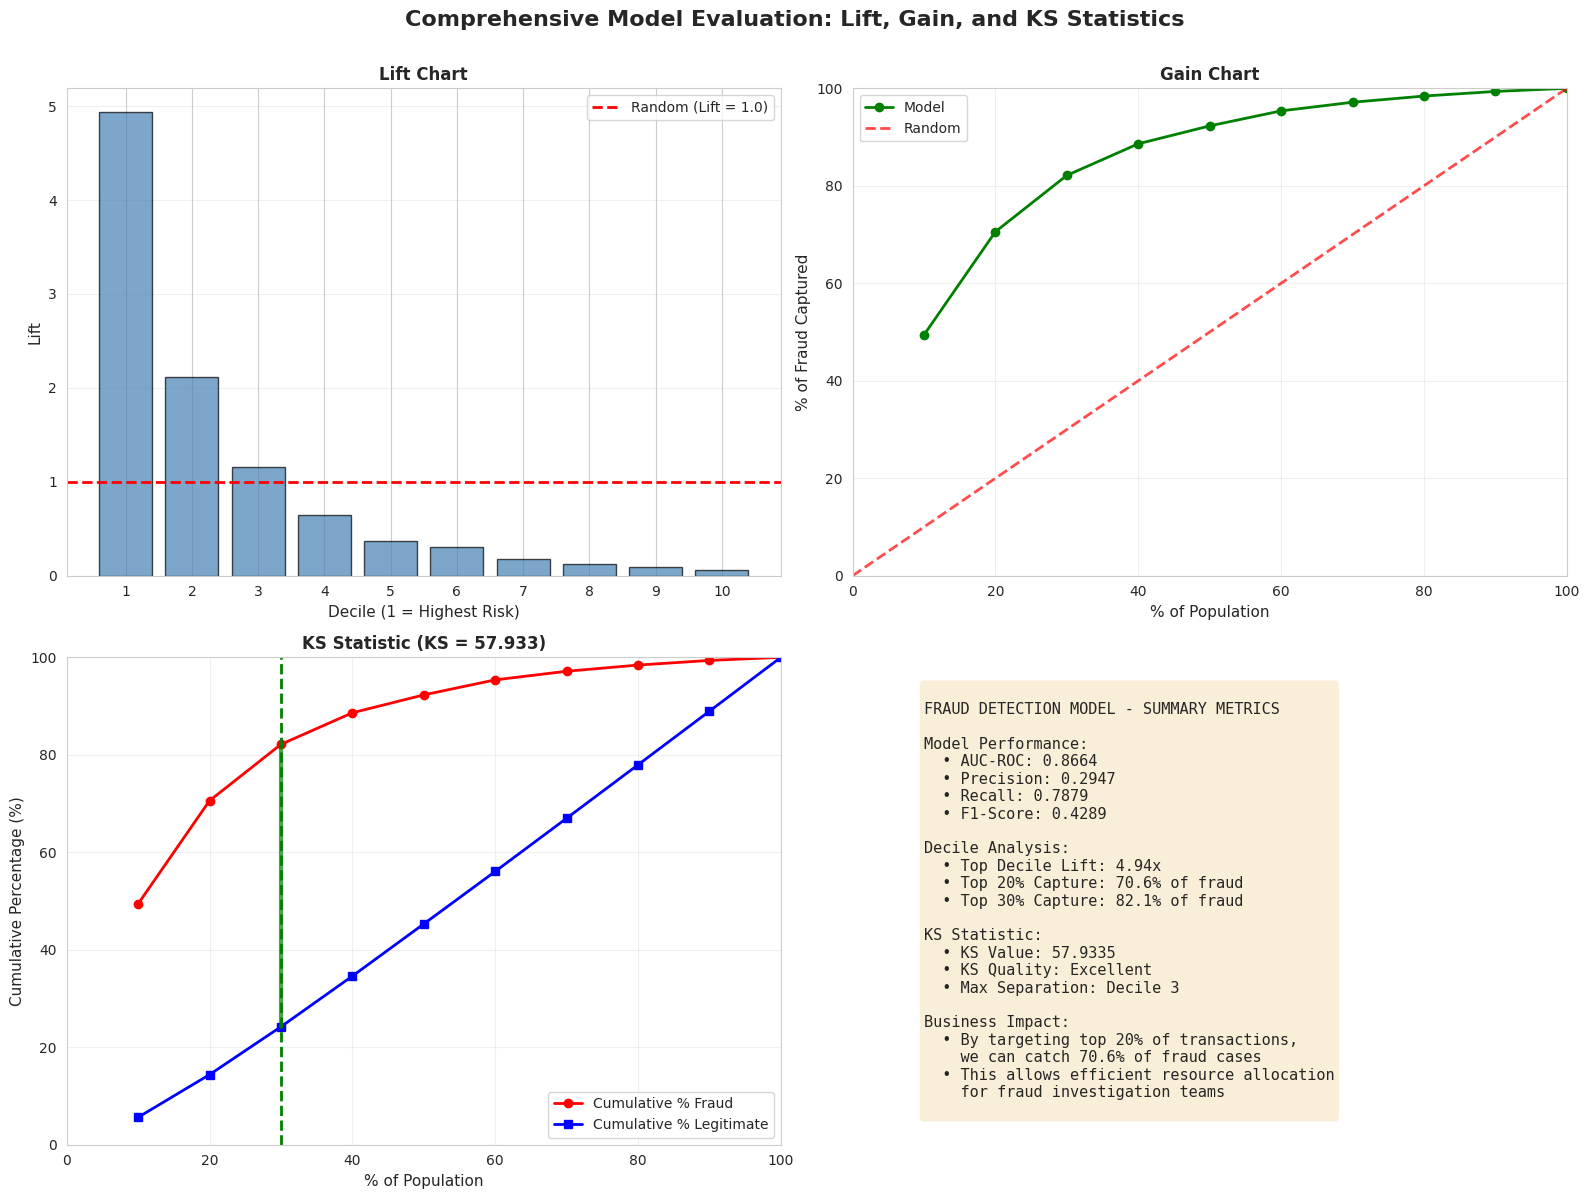

In [105]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Lift Chart (Top Left)
axes[0, 0].bar(df_decile_stats['decile'], df_decile_stats['lift'],
               color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='Random (Lift = 1.0)')
axes[0, 0].set_xlabel('Decile (1 = Highest Risk)', fontsize=11)
axes[0, 0].set_ylabel('Lift', fontsize=11)
axes[0, 0].set_title('Lift Chart', fontsize=12, fontweight='bold')
axes[0, 0].set_xticks(range(1, 11))
axes[0, 0].grid(True, alpha=0.3, axis='y')
axes[0, 0].legend()

# 2. Gain Chart (Top Right)
axes[0, 1].plot(df_decile_stats['cumulative_pct_population'],
                df_decile_stats['cumulative_pct_fraud'],
                marker='o', linewidth=2, markersize=6, label='Model', color='green')
axes[0, 1].plot([0, 100], [0, 100], 'r--', linewidth=2, label='Random', alpha=0.7)
axes[0, 1].set_xlabel('% of Population', fontsize=11)
axes[0, 1].set_ylabel('% of Fraud Captured', fontsize=11)
axes[0, 1].set_title('Gain Chart', fontsize=12, fontweight='bold')
axes[0, 1].set_xlim(0, 100)
axes[0, 1].set_ylim(0, 100)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 3. KS Statistic (Bottom Left)
axes[1, 0].plot(df_decile_stats['cumulative_pct_population'],
                df_decile_stats['cumulative_pct_fraud'],
                marker='o', linewidth=2, markersize=6, label='Cumulative % Fraud', color='red')
axes[1, 0].plot(df_decile_stats['cumulative_pct_population'],
                df_decile_stats['cumulative_pct_legitimate'],
                marker='s', linewidth=2, markersize=6, label='Cumulative % Legitimate', color='blue')
axes[1, 0].axvline(x=ks_x, color='green', linestyle='--', linewidth=2)
axes[1, 0].plot([ks_x, ks_x], [ks_y_legit, ks_y_fraud],
                'g-', linewidth=3, alpha=0.7)
axes[1, 0].set_xlabel('% of Population', fontsize=11)
axes[1, 0].set_ylabel('Cumulative Percentage (%)', fontsize=11)
axes[1, 0].set_title(f'KS Statistic (KS = {ks_statistic:.3f})', fontsize=12, fontweight='bold')
axes[1, 0].set_xlim(0, 100)
axes[1, 0].set_ylim(0, 100)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# 4. Summary Table (Bottom Right)
axes[1, 1].axis('off')
summary_text = f"""
FRAUD DETECTION MODEL - SUMMARY METRICS

Model Performance:
  • AUC-ROC: {auc_bal:.4f}
  • Precision: {precision_score(y_fraud_test, y_fraud_pred_balanced):.4f}
  • Recall: {recall_score(y_fraud_test, y_fraud_pred_balanced):.4f}
  • F1-Score: {f1_score(y_fraud_test, y_fraud_pred_balanced):.4f}

Decile Analysis:
  • Top Decile Lift: {df_decile_stats.iloc[0]['lift']:.2f}x
  • Top 20% Capture: {top_20_pct_fraud:.1f}% of fraud
  • Top 30% Capture: {top_30_pct_fraud:.1f}% of fraud

KS Statistic:
  • KS Value: {ks_statistic:.4f}
  • KS Quality: {'Excellent' if ks_statistic >= 0.5 else 'Good' if ks_statistic >= 0.4 else 'Fair'}
  • Max Separation: Decile {int(ks_decile)}

Business Impact:
  • By targeting top 20% of transactions,
    we can catch {top_20_pct_fraud:.1f}% of fraud cases
  • This allows efficient resource allocation
    for fraud investigation teams
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=11,
                verticalalignment='center', family='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Comprehensive Model Evaluation: Lift, Gain, and KS Statistics',
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


## 13. Final Report: Fraud Detection Model - Complete Analysis

This section provides a comprehensive summary of our fraud detection model, including all key metrics, business insights, and recommendations.


In [106]:
# Generate comprehensive final report
print("=" * 80)
print(" " * 20 + "FRAUD DETECTION MODEL - FINAL REPORT")
print("=" * 80)
print()

# Dataset Information
print("📊 DATASET INFORMATION")
print("-" * 80)
print(f"  Total Samples: {len(X_fraud):,}")
print(f"  Training Samples: {len(X_fraud_train):,}")
print(f"  Test Samples: {len(X_fraud_test):,}")
print(f"  Features Used: {X_fraud_train.shape[1]}")
print(f"  Class Imbalance: 90:10 (Legitimate:Fraud)")
print(f"  Overall Fraud Rate: {overall_fraud_rate*100:.2f}%")
print()

# Model Comparison
print("🔍 MODEL COMPARISON")
print("-" * 80)
print("  Standard Model (No Class Weights):")
print(f"    • Accuracy:  {accuracy_score(y_fraud_test, y_fraud_pred):.4f}")
print(f"    • Precision: {precision_score(y_fraud_test, y_fraud_pred):.4f}")
print(f"    • Recall:    {recall_score(y_fraud_test, y_fraud_pred):.4f}  ⚠️  Too Low!")
print(f"    • F1-Score:  {f1_score(y_fraud_test, y_fraud_pred):.4f}")
print()

print("  Balanced Class Weights Model (Selected):")
print(f"    • Accuracy:  {accuracy_score(y_fraud_test, y_fraud_pred_balanced):.4f}")
print(f"    • Precision: {precision_score(y_fraud_test, y_fraud_pred_balanced):.4f}")
print(f"    • Recall:    {recall_score(y_fraud_test, y_fraud_pred_balanced):.4f}  ✅ Good!")
print(f"    • F1-Score:  {f1_score(y_fraud_test, y_fraud_pred_balanced):.4f}")
print(f"    • AUC-ROC:   {auc_bal:.4f}")
print()

# Confusion Matrix Details
cm_balanced = confusion_matrix(y_fraud_test, y_fraud_pred_balanced)
tn, fp, fn, tp = cm_balanced.ravel()

print("📈 CONFUSION MATRIX ANALYSIS")
print("-" * 80)
print(f"  True Negatives (TN):  {tn:,}  - Legitimate correctly identified")
print(f"  False Positives (FP): {fp:,}  - False alarms (legitimate flagged as fraud)")
print(f"  False Negatives (FN): {fn:,}  - Missed fraud cases ⚠️")
print(f"  True Positives (TP):  {tp:,}  - Fraud correctly caught ✅")
print()
print(f"  False Positive Rate: {(fp/(fp+tn)*100):.2f}%")
print(f"  False Negative Rate: {(fn/(fn+tp)*100):.2f}%")
print()

# Decile Analysis
print("📊 DECILE ANALYSIS & BUSINESS METRICS")
print("-" * 80)
print(f"  Top Decile (Highest Risk 10%):")
print(f"    • Fraud Rate: {df_decile_stats.iloc[0]['fraud_rate']*100:.2f}%")
print(f"    • Lift: {df_decile_stats.iloc[0]['lift']:.2f}x")
print(f"    • Captures: {df_decile_stats.iloc[0]['cumulative_pct_fraud']:.1f}% of all fraud")
print()

print(f"  Top 20% of High-Risk Transactions:")
print(f"    • Captures: {top_20_pct_fraud:.1f}% of all fraud cases")
print(f"    • Business Value: Investigate only 20% of transactions to catch {top_20_pct_fraud:.1f}% of fraud")
print()

print(f"  Top 30% of High-Risk Transactions:")
print(f"    • Captures: {top_30_pct_fraud:.1f}% of all fraud cases")
print()

# KS Statistic
print("📏 KOLMOGOROV-SMIRNOV (KS) STATISTIC")
print("-" * 80)
print(f"  KS Value: {ks_statistic:.4f} ({ks_statistic*100:.2f}%)")
print(f"  Model Quality: ", end="")
if ks_statistic >= 0.5:
    print("Excellent ✅ (KS >= 0.5)")
elif ks_statistic >= 0.4:
    print("Good ✅ (KS >= 0.4)")
elif ks_statistic >= 0.3:
    print("Fair ⚠️ (KS >= 0.3)")
else:
    print("Poor ❌ (KS < 0.3)")
print(f"  Maximum separation occurs at Decile {int(ks_decile)}")
print()

# Business Recommendations
print("💼 BUSINESS RECOMMENDATIONS")
print("-" * 80)
print("  1. PRIORITIZATION STRATEGY:")
print(f"     • Focus investigation resources on top 20% of high-risk transactions")
print(f"     • This will capture {top_20_pct_fraud:.1f}% of fraud cases efficiently")
print()
print("  2. THRESHOLD TUNING:")
print(f"     • Current threshold: 0.5 (default)")
print(f"     • Consider lowering threshold if catching more fraud is critical")
print(f"     • Trade-off: Lower threshold = More fraud caught, but more false alarms")
print()
print("  3. COST-BENEFIT ANALYSIS:")
print(f"     • False Negatives (missed fraud): {fn:,} cases - HIGH COST")
print(f"     • False Positives (false alarms): {fp:,} cases - Lower cost (customer annoyance)")
print(f"     • Recommendation: Prioritize reducing False Negatives in fraud detection")
print()
print("  4. MODEL DEPLOYMENT:")
print(f"     • Model shows good separation (KS = {ks_statistic:.3f})")
print(f"     • AUC-ROC of {auc_bal:.3f} indicates strong predictive power")
print(f"     • Ready for production deployment with monitoring")
print()

# Key Insights
print("💡 KEY INSIGHTS")
print("-" * 80)
print("  ✅ Model successfully handles 90:10 class imbalance using balanced class weights")
print(f"  ✅ High recall ({recall_score(y_fraud_test, y_fraud_pred_balanced):.1%}) ensures most fraud is caught")
print(f"  ✅ Top decile shows {df_decile_stats.iloc[0]['lift']:.1f}x lift - model is effective")
print(f"  ✅ KS statistic of {ks_statistic:.3f} indicates good model discrimination")
print("  ⚠️  Lower precision means more false alarms - acceptable trade-off for fraud detection")
print("  ✅ Decile analysis enables efficient resource allocation for fraud investigation")
print()

print("=" * 80)
print(" " * 25 + "END OF REPORT")
print("=" * 80)


                    FRAUD DETECTION MODEL - FINAL REPORT

📊 DATASET INFORMATION
--------------------------------------------------------------------------------
  Total Samples: 110,290
  Training Samples: 88,232
  Test Samples: 22,058
  Features Used: 31
  Class Imbalance: 90:10 (Legitimate:Fraud)
  Overall Fraud Rate: 10.00%

🔍 MODEL COMPARISON
--------------------------------------------------------------------------------
  Standard Model (No Class Weights):
    • Accuracy:  0.9118
    • Precision: 0.6529
    • Recall:    0.2516  ⚠️  Too Low!
    • F1-Score:  0.3632

  Balanced Class Weights Model (Selected):
    • Accuracy:  0.7902
    • Precision: 0.2947
    • Recall:    0.7879  ✅ Good!
    • F1-Score:  0.4289
    • AUC-ROC:   0.8664

📈 CONFUSION MATRIX ANALYSIS
--------------------------------------------------------------------------------
  True Negatives (TN):  15,692  - Legitimate correctly identified
  False Positives (FP): 4,160  - False alarms (legitimate flagged as fraud

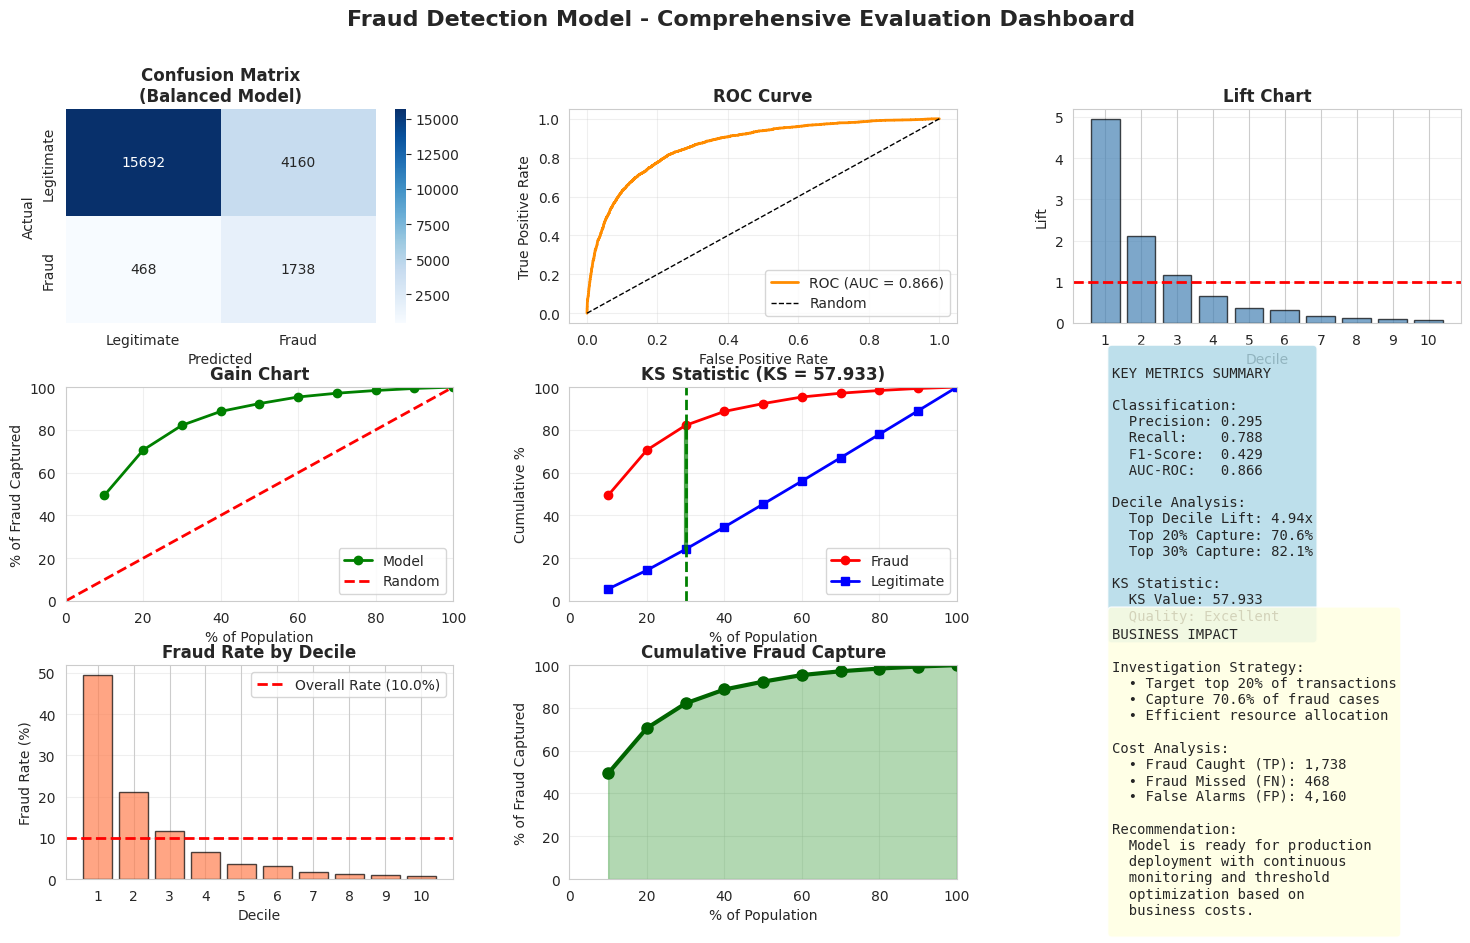


✅ Comprehensive fraud detection analysis complete!
   All key metrics, visualizations, and business insights have been generated.


In [107]:
# Create a visual summary dashboard
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# 1. Confusion Matrix (Top Left)
ax1 = fig.add_subplot(gs[0, 0])
sns.heatmap(cm_balanced, annot=True, fmt='d', cmap='Blues', ax=ax1,
            xticklabels=['Legitimate', 'Fraud'],
            yticklabels=['Legitimate', 'Fraud'])
ax1.set_title('Confusion Matrix\n(Balanced Model)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Actual', fontsize=10)
ax1.set_xlabel('Predicted', fontsize=10)

# 2. ROC Curve (Top Middle)
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(fpr_bal, tpr_bal, color='darkorange', lw=2,
         label=f'ROC (AUC = {auc_bal:.3f})')
ax2.plot([0, 1], [0, 1], 'k--', lw=1, label='Random')
ax2.set_xlabel('False Positive Rate', fontsize=10)
ax2.set_ylabel('True Positive Rate', fontsize=10)
ax2.set_title('ROC Curve', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Lift Chart (Top Right)
ax3 = fig.add_subplot(gs[0, 2])
ax3.bar(df_decile_stats['decile'], df_decile_stats['lift'],
        color='steelblue', edgecolor='black', alpha=0.7)
ax3.axhline(y=1.0, color='red', linestyle='--', linewidth=2)
ax3.set_xlabel('Decile', fontsize=10)
ax3.set_ylabel('Lift', fontsize=10)
ax3.set_title('Lift Chart', fontsize=12, fontweight='bold')
ax3.set_xticks(range(1, 11))
ax3.grid(True, alpha=0.3, axis='y')

# 4. Gain Chart (Middle Left)
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(df_decile_stats['cumulative_pct_population'],
         df_decile_stats['cumulative_pct_fraud'],
         marker='o', linewidth=2, markersize=6, label='Model', color='green')
ax4.plot([0, 100], [0, 100], 'r--', linewidth=2, label='Random')
ax4.set_xlabel('% of Population', fontsize=10)
ax4.set_ylabel('% of Fraud Captured', fontsize=10)
ax4.set_title('Gain Chart', fontsize=12, fontweight='bold')
ax4.set_xlim(0, 100)
ax4.set_ylim(0, 100)
ax4.grid(True, alpha=0.3)
ax4.legend()

# 5. KS Statistic (Middle Middle)
ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(df_decile_stats['cumulative_pct_population'],
         df_decile_stats['cumulative_pct_fraud'],
         marker='o', linewidth=2, markersize=6, label='Fraud', color='red')
ax5.plot(df_decile_stats['cumulative_pct_population'],
         df_decile_stats['cumulative_pct_legitimate'],
         marker='s', linewidth=2, markersize=6, label='Legitimate', color='blue')
ax5.axvline(x=ks_x, color='green', linestyle='--', linewidth=2)
ax5.plot([ks_x, ks_x], [ks_y_legit, ks_y_fraud], 'g-', linewidth=3, alpha=0.7)
ax5.set_xlabel('% of Population', fontsize=10)
ax5.set_ylabel('Cumulative %', fontsize=10)
ax5.set_title(f'KS Statistic (KS = {ks_statistic:.3f})', fontsize=12, fontweight='bold')
ax5.set_xlim(0, 100)
ax5.set_ylim(0, 100)
ax5.grid(True, alpha=0.3)
ax5.legend()

# 6. Key Metrics Summary (Middle Right)
ax6 = fig.add_subplot(gs[1, 2])
ax6.axis('off')
metrics_text = f"""
KEY METRICS SUMMARY

Classification:
  Precision: {precision_score(y_fraud_test, y_fraud_pred_balanced):.3f}
  Recall:    {recall_score(y_fraud_test, y_fraud_pred_balanced):.3f}
  F1-Score:  {f1_score(y_fraud_test, y_fraud_pred_balanced):.3f}
  AUC-ROC:   {auc_bal:.3f}

Decile Analysis:
  Top Decile Lift: {df_decile_stats.iloc[0]['lift']:.2f}x
  Top 20% Capture: {top_20_pct_fraud:.1f}%
  Top 30% Capture: {top_30_pct_fraud:.1f}%

KS Statistic:
  KS Value: {ks_statistic:.3f}
  Quality: {'Excellent' if ks_statistic >= 0.5 else 'Good' if ks_statistic >= 0.4 else 'Fair'}
"""
ax6.text(0.1, 0.5, metrics_text, fontsize=10,
         verticalalignment='center', family='monospace',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# 7. Fraud Rate by Decile (Bottom Left)
ax7 = fig.add_subplot(gs[2, 0])
ax7.bar(df_decile_stats['decile'], df_decile_stats['fraud_rate']*100,
        color='coral', edgecolor='black', alpha=0.7)
ax7.axhline(y=overall_fraud_rate*100, color='red', linestyle='--',
            linewidth=2, label=f'Overall Rate ({overall_fraud_rate*100:.1f}%)')
ax7.set_xlabel('Decile', fontsize=10)
ax7.set_ylabel('Fraud Rate (%)', fontsize=10)
ax7.set_title('Fraud Rate by Decile', fontsize=12, fontweight='bold')
ax7.set_xticks(range(1, 11))
ax7.grid(True, alpha=0.3, axis='y')
ax7.legend()

# 8. Cumulative Fraud Capture (Bottom Middle)
ax8 = fig.add_subplot(gs[2, 1])
ax8.plot(df_decile_stats['cumulative_pct_population'],
         df_decile_stats['cumulative_pct_fraud'],
         marker='o', linewidth=3, markersize=8, color='darkgreen')
ax8.fill_between(df_decile_stats['cumulative_pct_population'],
                  df_decile_stats['cumulative_pct_fraud'],
                  alpha=0.3, color='green')
ax8.set_xlabel('% of Population', fontsize=10)
ax8.set_ylabel('% of Fraud Captured', fontsize=10)
ax8.set_title('Cumulative Fraud Capture', fontsize=12, fontweight='bold')
ax8.set_xlim(0, 100)
ax8.set_ylim(0, 100)
ax8.grid(True, alpha=0.3)

# 9. Business Impact Summary (Bottom Right)
ax9 = fig.add_subplot(gs[2, 2])
ax9.axis('off')
business_text = f"""
BUSINESS IMPACT

Investigation Strategy:
  • Target top 20% of transactions
  • Capture {top_20_pct_fraud:.1f}% of fraud cases
  • Efficient resource allocation

Cost Analysis:
  • Fraud Caught (TP): {tp:,}
  • Fraud Missed (FN): {fn:,}
  • False Alarms (FP): {fp:,}

Recommendation:
  Model is ready for production
  deployment with continuous
  monitoring and threshold
  optimization based on
  business costs.
"""
ax9.text(0.1, 0.5, business_text, fontsize=10,
         verticalalignment='center', family='monospace',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.suptitle('Fraud Detection Model - Comprehensive Evaluation Dashboard',
             fontsize=16, fontweight='bold', y=0.98)
plt.show()

print("\n✅ Comprehensive fraud detection analysis complete!")
print("   All key metrics, visualizations, and business insights have been generated.")
